# Development of a NLP-inspired descriptor for solid solutions

This notebook is divided into four main sections:
- [generate all the symmetry irreducible structures by reading a CRYSTAL confcount output](#generate)
- [build the descriptor](#descriptor)
- [run the ML analysis](#ml)
- [write CRYSTAL input files and analyse CRYSTAL output files](#crystal)






#### Possible descriptors:
- neighbours_spatial_dist_all: descriptor for the structures (list of 2d arrays N_atoms x M_neighbours, where the M_neighbours depends on how many shells are included)
- neighbours_spatial_dist_all_sorted: like neighbours_spatial_dist_all, but storted row-sorted
- neighbours_spatial_dist_all_sorted_sliced: like neighbours_spatial_dist_all_sorted, but without the central atom number
- neighbours_spatial_dist_all_sorted_sliced_flat: like neighbours_spatial_dist_all_sorted, but without the central atom number, but as a flat array
- neighbours_spatial_dist_all_sorted_sliced_sum: like neighbours_spatial_dist_all_sorted_sliced, but summed columnwise


In [135]:
import sys
sys.path.insert(1, '../../crystal-code-tools/CRYSTALpytools/CRYSTALpytools//')

from crystal_io import *
from convert import *
'''from CRYSTALpytools.crystal_io import Crystal_output, Crystal_input, Crystal_density, Crystal_gui
from CRYSTALpytools.convert import cry_gui2pmg, cry_out2pmg
from CRYSTALpytools.utils import view_pmg
from CRYSTALpytools.calculate import cry_shrink
'''
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter
from ase.visualize import view

from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.surface import SlabGenerator
import numpy as np
import pandas as pd
import os
from pathlib import Path
import copy
import itertools
import shutil as sh

from pymatgen.ext.matproj import MPRester
import json
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

In [2]:
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

# <a id='generate'>Generate all the symmetry irreducible structures</a>

## Large set

In [3]:
new_atom = 'Mg'

#cry_output = Crystal_output('data/classification/ml/cao_CONFCNT.out')
cry_output = Crystal_output().read_cry_output('data/crystal/cao_confcount.out')

cry_output.get_config_analysis()

#original_structure = cry_gui2pmg('data/classification/ml/cao_CONFCNT.gui')
original_structure_gui =  Crystal_gui().read_cry_gui('data/crystal/cao_confcount.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures = []
ca_atoms = []
mg_atoms = []
for j,substitutions in enumerate(cry_output.atom_type2):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures.append(new_structure)
    ca_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    mg_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())


### High tol

In [70]:
new_atom = 'Mg'

#cry_output = Crystal_output('data/classification/ml/cao_CONFCNT.out')
cry_output = Crystal_output().read_cry_output('data/crystal/high_tol/cao_confcount.out')

cry_output.get_config_analysis()

#original_structure = cry_gui2pmg('data/classification/ml/cao_CONFCNT.gui')
original_structure_gui =  Crystal_gui().read_cry_gui('data/crystal/high_tol/cao_confcount.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures = []
ca_atoms = []
mg_atoms = []
for j,substitutions in enumerate(cry_output.atom_type2):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures.append(new_structure)
    ca_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    mg_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())


In [71]:
len(structures)

4023

## Small set

In [4]:
new_atom = 'Mg'

#cry_output = Crystal_output('data/classification/ml/cao_CONFCNT.out')
cry_output = Crystal_output().read_cry_output('data/crystal/cao_confcount_2.out')

cry_output.get_config_analysis()

#original_structure = cry_gui2pmg('data/classification/ml/cao_CONFCNT.gui')
original_structure_gui =  Crystal_gui().read_cry_gui('data/crystal/cao_confcount_2.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures = []
ca_atoms = []
mg_atoms = []
for j,substitutions in enumerate(cry_output.atom_type2):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures.append(new_structure)
    ca_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    mg_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())


In [6]:
len(structures)

4

# <a id='descriptor'>The descriptor</a> - The magic happens here

Each element of the neighbours_spatial_dist_all (one element per structure) is a 2D array whose rows correspond to an atom and the array contains:
- 0 = atom number of the atom whose neighbours I'm analysing
- 1:6 = atomic numbers of the atoms in the first coord shell
- 7:19 = atomic numbers of the atoms in the second coord shell
- 20:28 = atomic numbers of the atoms in the third coord shell

These atomic numbers are ordered following a spatial analysis. They are written starting from the atoms below the atom 0 and moving upwards.

## Spatial distribution analysis

In [247]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    if np.around(az,6) ==  np.around(2*np.pi,6) \
    or np.around(az,6) ==  -np.around(2*np.pi,6):
        az = 0.
    if np.around(az,6) < 0.:
        az = np.round(2*np.pi+az,6)
    return [round(r,6), round(el,6), round(az,6) ]
#cart2sph(0,0,-1)

In [19]:
def cart2sph_array(array):
    sph_coordinates = []
    for line in array:
        x = line[0]
        y = line[1]
        z = line[2]
        hxy = np.hypot(x, y)
        r = np.hypot(hxy, z)
        el = np.arctan2(z, hxy)
        az = np.arctan2(y, x)
        if np.around(az,6) ==  np.around(2*np.pi,6) \
        or np.around(az,6) ==  -np.around(2*np.pi,6):
            az = 0.
        if np.around(az,6) < 0.:
            az = np.round(2*np.pi+az,6)
        sph_coordinates.append([round(r,6), round(el,6), round(az,6) ])   
    return sph_coordinates

#cart2sph_array(np.array([[1,2,3],[4,5,6],[7,8,9]]))

### Shells

In [14]:
shells = np.unique(np.round(structures[0].distance_matrix[0],decimals=6),return_counts=True)[0].tolist()
shells

[0.0, 2.419086, 3.421104, 4.18998, 4.838172, 5.409241, 5.925527, 7.257258]

In [1]:
#SAVE
max_shell = 5
centered_sph_coords = []
centered_sph_coords_structure = []
neighbours_spatial_dist = []
neighbours_spatial_dist_all = []
shells_norm = copy.deepcopy(shells)
shells_norm[0] = 1.0
import time
#time0 = time.time()
#for k,structure in enumerate(structures[0:100]): #TMP only calculate 100 structures
for k,structure in enumerate(structures): 
    time0 = time.time()
    neighbours_spatial_dist = []
    
    for j in range(structure.num_sites):
        centered_sph_coords = []
        neighbours_spatial_dist_atom = []
        
        for m,n in enumerate(range(max_shell+1)):
            centered_sph_coords = []
            
            #atom_indices = np.where(np.round(structure.distance_matrix[j],5) == np.round(shells[n],5))[0].tolist()
            neighbours = structure.get_neighbors_in_shell(structure.sites[j].coords,shells[n],0.2)
            #print(len(neighbours))
            new_cart_coords = [x.coords.tolist() for x in neighbours]
            atom_numbers = [x.specie.number for x in neighbours]
            #print(atom_numbers)
            centered_cart_coords = np.array(new_cart_coords)-structure.cart_coords[j]
            centered_sph_coords = cart2sph_array(centered_cart_coords)
            
            spatial_distribution = np.argsort(np.array(centered_sph_coords)[:,1]*10 +\
                                              np.array(centered_sph_coords)[:,2])
            #the_d = np.array(centered_sph_coords)[:,1]*10 +\
                                              #np.array(centered_sph_coords)[:,2]
            #print((np.array(atom_numbers)[spatial_distribution])/(shells_norm[n]))
            
            #SORT DESCRIPTOR
            #neighbours_spatial_dist_atom.extend(np.sort(np.array(atom_numbers)))
            
            neighbours_spatial_dist_atom.extend((np.array(atom_numbers)[spatial_distribution]))
            #neighbours_spatial_dist_atom.extend((np.array(atom_numbers)[spatial_distribution])/(shells_norm[n]))
            #neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atom_indices)[spatial_distribution]]*(1)).tolist())
        #SAVE
        neighbours_spatial_dist.append(neighbours_spatial_dist_atom)
        
    #print(time.time()-time0)
    neighbours_spatial_dist_all.append(neighbours_spatial_dist) 
#neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)        

NameError: name 'copy' is not defined

In [18]:
#OLD
shells = np.unique(np.round(structures[0].distance_matrix[0],decimals=6),return_counts=True)[0].tolist()
max_shell = 5
centered_sph_coords = []
centered_sph_coords_structure = []
neighbours_spatial_dist = []
neighbours_spatial_dist_all = []
import time
#time0 = time.time()
#for k,structure in enumerate(structures[0:100]): #TMP only calculate 100 structures
for k,structure in enumerate(structures): 
    time0 = time.time()
    neighbours_spatial_dist = []
    
    for j in range(structure.num_sites):
        centered_sph_coords = []
        neighbours_spatial_dist_atom = []
        
        for n in range(max_shell+1):
            atom_indices = np.where(np.round(structure.distance_matrix[j],5) == np.round(shells[n],5))[0].tolist()
            centered_sph_coords = []
            for i in atom_indices:
                
                translation_vector = structure.sites[j].distance_and_image(structure.sites[i])[1]
                new_cart_coords = structure.cart_coords[i]+(translation_vector*structure.lattice.abc)
                centered_cart_coords = new_cart_coords-structure.cart_coords[j] 

                centered_sph_coords.append(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))        
            #print(centered_sph_coords)
            spatial_distribution = np.argsort(np.array(centered_sph_coords)[:,1]*10 +\
                                              np.array(centered_sph_coords)[:,2])


            neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atom_indices)[spatial_distribution]]*(1)).tolist())
        #SAVE
        neighbours_spatial_dist.append(neighbours_spatial_dist_atom)
        
    #print(time.time()-time0)
    neighbours_spatial_dist_all.append(neighbours_spatial_dist) 
#neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)        

NameError: name 'cart2sph' is not defined

In [191]:
np.array(neighbours_spatial_dist_all)[0]

array([[12,  8,  8,  8,  8,  8,  8, 20, 12, 20, 12, 12, 20,  8,  8, 20],
       [12,  8,  8,  8,  8,  8,  8, 12, 20, 12, 20, 12, 20,  8,  8, 20],
       [12,  8,  8,  8,  8,  8,  8, 20, 12, 20, 12, 20, 12,  8,  8, 20],
       [12,  8,  8,  8,  8,  8,  8, 12, 20, 20, 20, 12, 12,  8,  8, 20],
       [20,  8,  8,  8,  8,  8,  8, 20, 12, 20, 12, 20, 12,  8,  8, 12],
       [20,  8,  8,  8,  8,  8,  8, 20, 20, 20, 12, 12, 12,  8,  8, 12],
       [20,  8,  8,  8,  8,  8,  8, 20, 12, 20, 12, 12, 20,  8,  8, 12],
       [20,  8,  8,  8,  8,  8,  8, 20, 12, 12, 20, 20, 12,  8,  8, 12],
       [ 8, 20, 12, 20, 12, 20, 12,  8,  8,  8,  8,  8,  8, 12, 20,  8],
       [ 8, 12, 20, 12, 12, 20, 20,  8,  8,  8,  8,  8,  8, 20, 12,  8],
       [ 8, 20, 20, 12, 20, 12, 12,  8,  8,  8,  8,  8,  8, 12, 20,  8],
       [ 8, 12, 20, 12, 20, 20, 12,  8,  8,  8,  8,  8,  8, 12, 20,  8],
       [ 8, 20, 12, 12, 20, 20, 12,  8,  8,  8,  8,  8,  8, 20, 12,  8],
       [ 8, 20, 20, 20, 12, 12, 12,  8,  8,  8,  8,

### pymatgen.analysis.local_env

In [65]:
'''from pymatgen.analysis.local_env import NearNeighbors
cnn = CrystalNN() # using default params

N = 0 # Site of interest, can be anything in [0, num_sites - 1]
info = cnn.get_nn_info(structure,0)
info'''

[{'site': PeriodicSite: O (-2.4191, 0.0000, 0.0000) [0.2500, -0.2500, -0.2500],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 11},
 {'site': PeriodicSite: O (2.4191, 0.0000, 0.0000) [-0.2500, 0.2500, 0.2500],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 12},
 {'site': PeriodicSite: O (0.0000, -2.4191, 0.0000) [-0.2500, 0.2500, -0.2500],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 13},
 {'site': PeriodicSite: O (0.0000, 0.0000, 2.4191) [0.2500, 0.2500, -0.2500],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 9},
 {'site': PeriodicSite: O (0.0000, 0.0000, -2.4191) [-0.2500, -0.2500, 0.2500],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 14},
 {'site': PeriodicSite: O (0.0000, 2.4191, 0.0000) [0.2500, -0.2500, 0.2500],
  'image': (0, 0, 0),
  'weight': 1,
  'site_index': 10}]

In [262]:
'''for site in structures[0].sites:
    #print(site.coords)
    neighbours = structures[0].get_neighbors_in_shell(site.coords,shells[1],0.2) 
    print([x.coords for x in neighbours])'''

'for site in structures[0].sites:\n    #print(site.coords)\n    neighbours = structures[0].get_neighbors_in_shell(site.coords,shells[1],0.2) \n    print([x.coords for x in neighbours])'

In [263]:
'''from pymatgen.analysis.local_env import NearNeighbors
cnn = CrystalNN() # using default params

N = 0 # Site of interest, can be anything in [0, num_sites - 1]
numbers = []
positions = []
info = cnn.get_nn_shell_info(structure, 0,4)
for i, site in enumerate(info):
    #print(structures[0].get_distance(N, site['site_index']),site['site_index'])
    print(site['site'].specie.number,site['site'].coords)
    numbers.append(site['site'].specie.number)
    positions.append(site['site'].coords)
cell = np.eye(3)*10.
vview(Structure(cell,numbers, positions,coords_are_cartesian=False))'''

"from pymatgen.analysis.local_env import NearNeighbors\ncnn = CrystalNN() # using default params\n\nN = 0 # Site of interest, can be anything in [0, num_sites - 1]\nnumbers = []\npositions = []\ninfo = cnn.get_nn_shell_info(structure, 0,4)\nfor i, site in enumerate(info):\n    #print(structures[0].get_distance(N, site['site_index']),site['site_index'])\n    print(site['site'].specie.number,site['site'].coords)\n    numbers.append(site['site'].specie.number)\n    positions.append(site['site'].coords)\ncell = np.eye(3)*10.\nvview(Structure(cell,numbers, positions,coords_are_cartesian=False))"

## Selected structures

In [21]:
neighbours_spatial_dist_all_json = json.dumps(neighbours_spatial_dist_all)
jsonFile = open('data/classification/ml/neighbours_spatial_dist_all_5.json', "w")
jsonFile.write(neighbours_spatial_dist_all_json)
jsonFile.close()

TypeError: Object of type int64 is not JSON serializable

In [31]:
import shutil as sh
for i in range(4023):
    sh.copy('data/crystal/cell/CaMgO_cell_%s.gui'%i, 'data/crystal/full/CaMgO_full_tmp_%s.gui'%i)
    #print('cp cell/CaMgO_cell_%s.f9 full_opt/CaMgO_full_tmp_%s.f9'%(i,i))

In [421]:
with open('data/classification/ml/neighbours_spatial_dist_all_1.json') as file:
    neighbours_spatial_dist_all = json.load(file)
neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)

In [428]:
import itertools
X = np.array(list(itertools.product([0, 1], repeat=27)))
X[0:10]

KeyboardInterrupt: 

In [9]:
#ALL AT ONCE
with open('data/classification/ml/neighbours_spatial_dist_all_4.json') as file:
    neighbours_spatial_dist_all = json.load(file)
neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)

neighbours_spatial_dist_all_sorted = []
sorting = []

for k,structure in enumerate(range(neighbours_spatial_dist_all.shape[0])):
    sorted_atoms = []
    for i in range(neighbours_spatial_dist_all.shape[1]):
        sorted_atoms.append(int(''.join([str(x) for x in neighbours_spatial_dist_all[k][i]])))
    sorting.append(np.argsort(np.array(sorted_atoms))) 
    neighbours_spatial_dist_all_sorted.append((np.array(neighbours_spatial_dist_all)[k][np.argsort(np.array(sorted_atoms))]).tolist())
neighbours_spatial_dist_all_sorted = np.array(neighbours_spatial_dist_all_sorted)   

neighbours_spatial_dist_all_sorted_sliced = neighbours_spatial_dist_all_sorted[:,:,1:]

n_structures = neighbours_spatial_dist_all_sorted_sliced.shape[0]
vector_len = neighbours_spatial_dist_all_sorted_sliced.shape[1] * neighbours_spatial_dist_all_sorted_sliced.shape[2]
neighbours_spatial_dist_all_sorted_sliced_flat = \
np.reshape(neighbours_spatial_dist_all_sorted_sliced, [n_structures,vector_len])

neighbours_spatial_dist_all_sorted_sliced_reduced = \
neighbours_spatial_dist_all_sorted_sliced[neighbours_spatial_dist_all_sorted_sliced != 8]

vector_len = int(neighbours_spatial_dist_all_sorted_sliced_reduced.shape[0]/n_structures)

neighbours_spatial_dist_all_sorted_sliced_reduced = \
np.reshape(neighbours_spatial_dist_all_sorted_sliced_reduced,[n_structures,vector_len])

### Sort by first atom

In [37]:
neighbours_spatial_dist_all_sorted = []
sorting = []

for k,structure in enumerate(range(neighbours_spatial_dist_all.shape[0])):
    sorted_atoms = []
    for i in range(neighbours_spatial_dist_all.shape[1]):
        sorted_atoms.append(int(''.join([str(x) for x in neighbours_spatial_dist_all[k][i]])))
    sorting.append(np.argsort(np.array(sorted_atoms))) 
    neighbours_spatial_dist_all_sorted.append((np.array(neighbours_spatial_dist_all)[k][np.argsort(np.array(sorted_atoms))]).tolist())
neighbours_spatial_dist_all_sorted = np.array(neighbours_spatial_dist_all_sorted)    


In [38]:
scaling_tmp = np.sort(structures[0].distance_matrix[0])
scaling_tmp[0] = 1.
scaling =  1/scaling_tmp[0:neighbours_spatial_dist_all_sorted.shape[2]]
print(scaling)
#scaling = np.array([0,10,10,10,10,10,10,])
neighbours_spatial_dist_all_sorted = neighbours_spatial_dist_all_sorted * scaling

[1.         0.41337926 0.41337926 0.41337926 0.41337926 0.41337926
 0.41337926 0.29230328 0.29230328 0.29230328 0.29230328 0.29230328
 0.29230328 0.29230328 0.29230328 0.29230328 0.29230328 0.29230328
 0.29230328 0.23866463 0.23866463 0.23866463 0.23866463 0.23866463
 0.23866463 0.23866463 0.23866463 0.20668963 0.20668963 0.20668963
 0.20668963 0.20668963 0.20668963]


### Slice

In [39]:
neighbours_spatial_dist_all_sorted_sliced = neighbours_spatial_dist_all_sorted[:,:,1:]

### Flatten

In [40]:
n_structures = neighbours_spatial_dist_all_sorted_sliced.shape[0]
vector_len = neighbours_spatial_dist_all_sorted_sliced.shape[1] * neighbours_spatial_dist_all_sorted_sliced.shape[2]
neighbours_spatial_dist_all_sorted_sliced_flat = \
np.reshape(neighbours_spatial_dist_all_sorted_sliced, [n_structures,vector_len])
#np.reshape(neighbours_spatial_dist_all_sorted_sliced, [4023,324])

### Reduced descriptor (no 8)

In [77]:
neighbours_spatial_dist_all_sorted_sliced_reduced.shape[0]/n_structures

1.0

In [78]:
len(neighbours_spatial_dist_all_sorted_sliced_reduced[0])

162

In [41]:
neighbours_spatial_dist_all_sorted_sliced_reduced = \
neighbours_spatial_dist_all_sorted_sliced[neighbours_spatial_dist_all_sorted_sliced != 8]

vector_len = int(neighbours_spatial_dist_all_sorted_sliced_reduced.shape[0]/n_structures)

neighbours_spatial_dist_all_sorted_sliced_reduced = \
np.reshape(neighbours_spatial_dist_all_sorted_sliced_reduced,[n_structures,vector_len])

In [39]:
for i in range(80):
    print(i,np.unique(neighbours_spatial_dist_all_sorted_sliced_reduced[:,0:i],axis=0).shape[0])

0 1
1 1
2 2
3 4
4 6
5 10
6 18
7 18
8 26
9 37
10 57
11 90
12 153
13 162
14 205
15 258
16 354
17 482
18 624
19 662
20 751
21 892
22 1079
23 1298
24 1514
25 1579
26 1674
27 1838
28 2076
29 2282
30 2496
31 2557
32 2592
33 2726
34 2891
35 3058
36 3209
37 3246
38 3250
39 3325
40 3425
41 3525
42 3606
43 3628
44 3629
45 3670
46 3715
47 3773
48 3832
49 3836
50 3836
51 3863
52 3890
53 3937
54 3951
55 3951
56 3954
57 3965
58 3979
59 3993
60 4001
61 4002
62 4002
63 4004
64 4009
65 4016
66 4016
67 4018
68 4018
69 4018
70 4019
71 4020
72 4020
73 4022
74 4022
75 4023
76 4023
77 4023
78 4023
79 4023


### Shorten the descriptor

In [7]:
neighbours_spatial_dist_all_sorted_sliced_reduced_short = \
neighbours_spatial_dist_all_sorted_sliced_reduced[:,0:74]

In [8]:
neighbours_spatial_dist_all_sorted_sliced_reduced_short

array([[12, 12, 12, ..., 12, 20, 20],
       [12, 12, 12, ..., 12, 20, 20],
       [12, 12, 12, ..., 12, 20, 20],
       ...,
       [12, 12, 20, ..., 20, 20, 12],
       [12, 12, 20, ..., 20, 20, 12],
       [12, 12, 20, ..., 20, 20, 12]])

# Reverse

In [54]:
neighbours_spatial_dist_all_sorted_sliced_reduced[0]

array([12, 20, 12, 20, 20, 20, 20, 12, 20, 20, 20, 20, 12, 20, 20, 20, 20,
       20, 12, 20, 20, 12, 20, 20, 20, 12, 12, 20, 20, 20, 20, 12, 20, 20,
       20, 20, 20, 20, 20, 12, 20, 12, 20, 20, 20, 20, 12, 12, 20, 20, 20,
       20, 12, 20, 12, 20, 12, 20, 20, 20, 12, 20, 20, 12, 20, 12, 20, 20,
       20, 12, 20, 20, 12, 20, 20, 12, 20, 20, 20, 20, 20, 12, 20, 20, 12,
       20, 20, 20, 12, 20, 20, 20, 20, 20, 20, 20, 20, 12, 20, 20, 20, 20,
       12, 20, 20, 12, 20, 20, 20, 12, 20, 20, 20, 20, 12, 20, 20, 20, 20,
       20, 20, 12, 20, 20, 20, 20, 20, 12, 20, 20, 20, 20, 20, 12, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 12, 20, 20, 20, 20, 12, 20,
       20, 12, 20, 20, 20, 12, 20, 20, 20, 20, 20, 20, 20, 20, 12, 20, 20,
       12, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 12, 12, 20, 20,
       20, 20, 12, 20, 20, 20, 20, 20, 12, 20, 20, 20, 12, 12, 20, 20, 20,
       20, 20, 20, 20, 12, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       12, 12, 20, 12, 20

# Exhaustive search test

In [15]:
from itertools import permutations
#l = list(permutations([20]*3+[12]*1,r=4))
l = list(permutations([20,20,20,12],r=4))
np.unique(l)

NameError: name 'np' is not defined

In [92]:
neighbours_spatial_dist_all_sorted_sliced_flat = neighbours_spatial_dist_all_sorted_sliced_reduced

# <a id='ml'>Machine Learning</a>

### ML model

In [12]:
#X = neighbours_spatial_dist_all_sorted_sliced_reduced[cluster_central_strucure,:]
#X = neighbours_spatial_dist_all_sorted_sliced_reduced[structuress,:]
X = neighbours_spatial_dist_all_sorted_sliced_reduced
#X = neighbours_spatial_dist_all_sorted_sliced_reduced_short
#y = np.array(energies)[cluster_central_strucure]
y = np.array(energies_cell)
#y = np.array([energies,energies])
x = X

'''X_train = neighbours_spatial_dist_all_sorted_sliced_reduced[cluster_central_strucure,:]
other_structures = np.delete(np.arange(4023),cluster_central_strucure)
X_test = neighbours_spatial_dist_all_sorted_sliced_reduced[other_structures,:]
y_train = np.array(energies)[cluster_central_strucure]
y_test  = np.array(energies)[other_structures]'''

'X_train = neighbours_spatial_dist_all_sorted_sliced_reduced[cluster_central_strucure,:]\nother_structures = np.delete(np.arange(4023),cluster_central_strucure)\nX_test = neighbours_spatial_dist_all_sorted_sliced_reduced[other_structures,:]\ny_train = np.array(energies)[cluster_central_strucure]\ny_test  = np.array(energies)[other_structures]'

## Data normalisation

#### MinMaxScaler

In [195]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler 

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

scaler = MinMaxScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

#### StandardScaler

In [408]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler 

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

## k-Nearest Neighbour clustering 

### Find neighbours

In [34]:
#X = neighbours_spatial_dist_all_sorted_sliced_flat
nbrs = NearestNeighbors(n_neighbors=100, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
indices

array([[   0,    3,    2, ...,   32,   59,  985],
       [   1,    2,    3, ...,  233, 1130,  971],
       [   2,    1,    3, ...,   64,  550, 1730],
       ...,
       [4020, 3395, 3952, ..., 2964, 3872, 3655],
       [4021, 4016, 4012, ..., 3305, 3700, 3869],
       [4022, 3326, 3514, ..., 3620, 3868, 3541]])

### k-means

In [47]:
kmeans = KMeans(n_clusters=500, random_state=0).fit(neighbours_spatial_dist_all_sorted_sliced_reduced)
sort = np.argsort(kmeans.labels_)

In [27]:
kmeans.labels_[0:100]

array([49, 49, 49, 49, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 41, 41, 46, 46, 46, 46, 46, 46, 46, 46, 46,
       46, 46, 43, 41, 41,  2, 41, 41, 41, 41,  8, 46, 18, 18, 18, 18, 46,
       18, 18, 46, 46, 36, 36, 34, 18, 18, 36, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 46, 18, 18, 36, 18, 18, 36, 18, 18, 18, 18,
       18, 18, 18, 18, 22, 18, 18, 36, 18, 18, 36, 18, 36, 18, 18],
      dtype=int32)

In [28]:
kmeans.cluster_centers_

array([[12.        , 12.        , 12.        , ..., 12.76190476,
        13.65079365, 14.92063492],
       [12.        , 12.        , 12.        , ..., 13.07865169,
        16.85393258, 13.34831461],
       [12.        , 12.        , 12.        , ..., 13.42857143,
        13.85714286, 14.85714286],
       ...,
       [12.        , 12.        , 12.        , ..., 14.7012987 ,
        15.01298701, 15.84415584],
       [12.        , 12.        , 12.        , ..., 15.57723577,
        14.60162602, 16.03252033],
       [12.        , 12.        , 12.        , ..., 12.19047619,
        12.38095238, 14.0952381 ]])

### Distance from cluster center

In [48]:
cluster_center_distance = []
for i in range(len(structures)):
    cluster = kmeans.labels_[i]
    #dist = np.linalg.norm(neighbours_spatial_dist_all_sorted_sliced_flat[i]- kmeans.cluster_centers_[cluster])
    dist = np.linalg.norm(neighbours_spatial_dist_all_sorted_sliced_reduced[i]- kmeans.cluster_centers_[cluster])
    
    cluster_center_distance.append(dist)
cluster_center_distance = np.array(cluster_center_distance)

### Central structure

In [49]:
cluster_central_strucure = []
for i in range(kmeans.n_clusters):
    cluster_items = np.where(kmeans.labels_ == i)[0]
    central_structure = np.where(cluster_center_distance == np.min(cluster_center_distance[cluster_items]))[0][0]
    cluster_central_strucure.append(central_structure)

### Central structure + n_irreducible_atoms

In [37]:
n_irr_atoms = np.array(n_irr_atoms)
top = 0.1
for i in range(kmeans.n_clusters):
    cluster_items = np.where(kmeans.labels_ == i)[0]
    #print(cluster_items)
    cluster_sort = np.argsort(cluster_center_distance[cluster_items])
    #print( cluster_sort )
    n_structures = round(len(cluster_items)*top)
    top_structures = cluster_items[cluster_sort][0:n_structures]
    #print(top_structures)
    structure_min_atoms_top_index = np.argmin(n_irr_atoms[top_structures])
    #print( structure_min_atoms_top_index,np.min(n_irr_atoms[top_structures]) )
    structure_min_atoms = top_structures[structure_min_atoms_top_index]
    print(structure_min_atoms,n_irr_atoms[structure_min_atoms])

NameError: name 'n_irr_atoms' is not defined

### KNeighborsRegressor

In [17]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler 
from sklearn.model_selection import train_test_split

for i in range(2,10):    
    print()
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.95)

    scaler = StandardScaler()
    scaler = MinMaxScaler()
    scaler.fit(X_train)  
    X_train = scaler.transform(X_train)  
    X_test = scaler.transform(X_test)  
    
    model = KNeighborsRegressor(n_neighbors=i)
    model.fit(X_train,y_train)
    
    predictions_train_LR = model.predict(X_train)
    
    train_error_LR= mean_squared_error(y_train, predictions_train_LR)
    print('Train Error:',train_error_LR)
    #Test Error
    predictions_test_LR = model.predict(X_test)
    test_error_LR= mean_squared_error(y_test, predictions_test_LR)
    print('Test Error:', test_error_LR)
    #evaluate the R^2
    score_LR=model.score(X_train, y_train) #returns the R^2 score
    print('R^2 returned by the linear regression:',score_LR)
    
    
    


2
Train Error: 0.00039999863010130505
Test Error: 0.0011201523627730793
R^2 returned by the linear regression: 0.9042902528931878

3
Train Error: 0.0005233855958818181
Test Error: 0.0009442494996998504
R^2 returned by the linear regression: 0.8752942159082152

4
Train Error: 0.0004532360862195826
Test Error: 0.0009775707462686162
R^2 returned by the linear regression: 0.8576264127168982

5
Train Error: 0.0006385794073584284
Test Error: 0.0008758103349954939
R^2 returned by the linear regression: 0.8106977708872476

6
Train Error: 0.0005829743771811795
Test Error: 0.0009417202863134947
R^2 returned by the linear regression: 0.8173162019586543

7
Train Error: 0.0006203339284595977
Test Error: 0.0008101592868030184
R^2 returned by the linear regression: 0.8327684568487548

8
Train Error: 0.0006576142628184207
Test Error: 0.0010418543852924453
R^2 returned by the linear regression: 0.7983397148654268

9
Train Error: 0.0006857196613875775
Test Error: 0.0008769684793532006
R^2 returned by t

## Neural networks

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.5)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

#pipe = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(350,),random_state=1, max_iter=1000))

#pipe.fit(X_train, y_train)
#pipe.score(X_test, y_test)

regr = MLPRegressor(hidden_layer_sizes=(300,),random_state=1, max_iter=500,solver='lbfgs').fit(X_train, y_train)

In [20]:
from sklearn.metrics import mean_squared_error as mse
#Training Error
predictions_train_LR = regr.predict(X_train)
train_error_LR= mse(y_train, predictions_train_LR)
print('Training Error:',train_error_LR)
#Test Error
predictions_test_LR = regr.predict(X_test)
test_error_LR= mse(y_test, predictions_test_LR)
print('Test Error:', test_error_LR)
#evaluate the R^2
score_LR=regr.score(X_train, y_train) #returns the R^2 score
print('R^2 returned by the linear regression:',score_LR)

Training Error: 2.1365553156970135e-08
Test Error: 1122019562704.3523
R^2 returned by the linear regression: 0.9999923963729976


## Linear regression

In [64]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42,test_size=0.5)
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.50)

#create the object
scaler=StandardScaler()
scaler=MinMaxScaler()
#fit mu and sigma and apply to X_train
X_train=scaler.fit_transform(X_train)
#apply the same transformation to the test set
X_test=scaler.transform(X_test)

reg = LinearRegression() #create the object
reg.fit(X_train, y_train)

LinearRegression()

In [94]:
from sklearn.metrics import mean_squared_error as mse
#Training Error
predictions_train_LR = reg.predict(X_train)
train_error_LR= mse(y_train, predictions_train_LR)
print('Training Error:',train_error_LR)
#Test Error
predictions_test_LR = reg.predict(X_test)
test_error_LR= mse(y_test, predictions_test_LR)
print('Test Error:', test_error_LR)
#evaluate the R^2
score_LR=reg.score(X_train, y_train) #returns the R^2 score
print('R^2 returned by the linear regression:',score_LR)

Training Error: 1.5051402709721658e+20
Test Error: 2.5275881574097755e+20
R^2 returned by the linear regression: -5.287405411034404e+22


In [216]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

#pipe = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(350,),random_state=1, max_iter=1000))

#pipe.fit(X_train, y_train)
#pipe.score(X_test, y_test)
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)


regr = MLPRegressor(hidden_layer_sizes=(350,),random_state=1, max_iter=1000).fit(X_train, y_train)

### Cosine similarity one by one

In [242]:
vector_descriptor = neighbours_spatial_dist_all_sorted_sliced_flat
a = vector_descriptor[0]
for i in range(len(neighbours_spatial_dist_all_sorted_sliced_flat)):   
    b = vector_descriptor[i]
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    print(cos_sim)

1.0000000000000002
0.9761646803900327
0.9737570723486219
0.9764054411941738
0.9679788130492358
0.9689418562658001
0.9699048994823645
0.9679788130492358
0.968460334657518
0.9706271818947877
0.9708679426989288
0.9682195738533769
0.9696641386782234
0.9682195738533769
0.9687010954616591
0.9689418562658001
0.9677380522450947
0.971349464307211
0.9701456602865056
0.968460334657518
0.9687010954616591
0.9677380522450947
0.9696641386782234
0.9677380522450947
0.9696641386782234
0.9694233778740823
0.9703864210906467
0.9679788130492358
0.968460334657518
0.9699048994823645
0.9701456602865056
0.9687010954616591
0.9689418562658001
0.9691826170699412
0.9689418562658001
0.9677380522450947
0.9701456602865056
0.9691826170699412
0.9689418562658001
0.9708679426989288
0.9696641386782234
0.9665342482243893
0.9703864210906467
0.9694233778740823
0.9665342482243893
0.9689418562658001
0.9718309859154932
0.9674972914409536
0.968460334657518
0.9703864210906467
0.9689418562658001
0.9703864210906467
0.966775009028530

0.9631635969664141
0.9638858793788373
0.9660527266161071
0.9634043577705552
0.9648489225954017
0.9646081617912606
0.962922836162273
0.9636451185746963
0.9674972914409536
0.9648489225954017
0.9655712050078249
0.9667750090285304
0.9665342482243893
0.9665342482243893
0.9626820753581319
0.9653304442036839
0.9660527266161071
0.9665342482243893
0.965811965811966
0.9667750090285304
0.9665342482243893
0.9660527266161071
0.9667750090285304
0.9662934874202482
0.9650896833995428
0.965811965811966
0.9655712050078249
0.9682195738533769
0.965811965811966
0.9665342482243893
0.9631635969664141
0.9662934874202482
0.9665342482243893
0.9636451185746963
0.9655712050078249
0.962922836162273
0.9665342482243893
0.9653304442036839
0.9667750090285304
0.9674972914409536
0.9670157698326715
0.9670157698326715
0.9631635969664141
0.9665342482243893
0.9662934874202482
0.965811965811966
0.9677380522450947
0.9662934874202482
0.9634043577705552
0.9626820753581319
0.9660527266161071
0.965811965811966
0.9641266401829784


### Cosine similarity matrix

In [110]:
vector_descriptor = np.array(neighbours_spatial_dist_all_sorted_sliced_flat)[sort]
cos_sim_2d = []
n_elements = len(neighbours_spatial_dist_all_sorted_sliced_flat)


for i in range(n_elements):
    cos_sim_line = []
    a = vector_descriptor[i]
    for j in range(n_elements):
        b = vector_descriptor[j]
        cos_sim_line.append(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))
    cos_sim_2d.append(cos_sim_line)

In [111]:
np.array(cos_sim_2d)

array([[1.        , 0.97818297, 0.97932456, ..., 0.97513873, 0.97970509,
        0.97666085],
       [0.97818297, 1.        , 0.98046615, ..., 0.97628032, 0.98084668,
        0.97792928],
       [0.97932456, 0.98046615, 1.        , ..., 0.97501189, 0.98059299,
        0.98160774],
       ...,
       [0.97513873, 0.97628032, 0.97501189, ..., 1.        , 0.97513873,
        0.97551926],
       [0.97970509, 0.98084668, 0.98059299, ..., 0.97513873, 1.        ,
        0.97754876],
       [0.97666085, 0.97792928, 0.98160774, ..., 0.97551926, 0.97754876,
        1.        ]])

In [112]:
tst = []
for i in dist_std_first:
    tst.append(sort.tolist().index(i))

NameError: name 'dist_std_first' is not defined

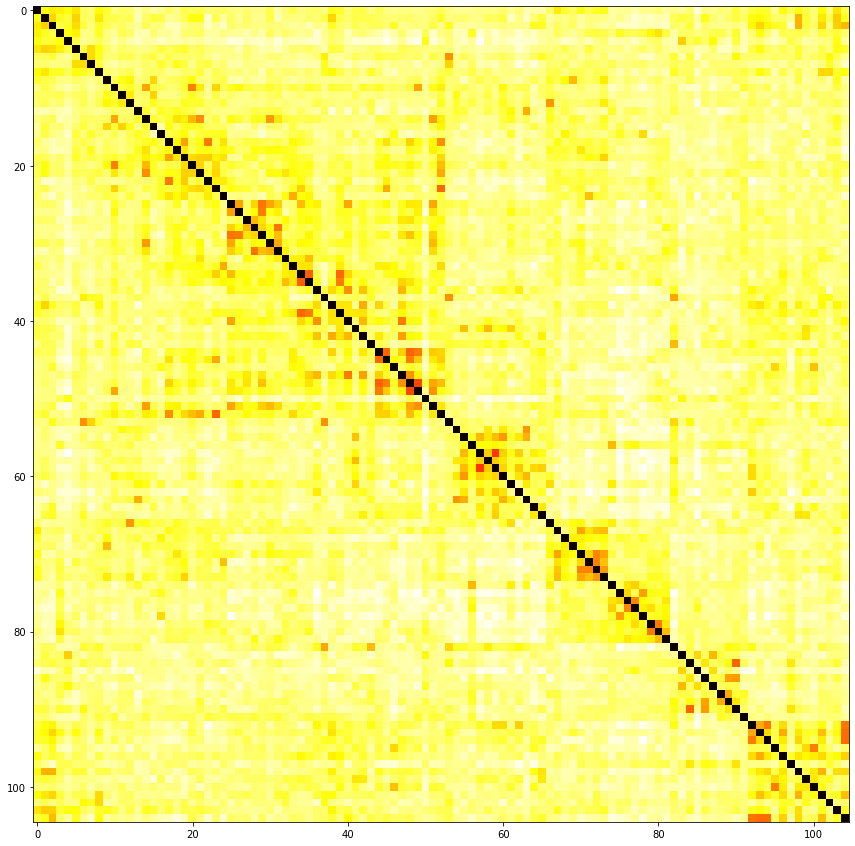

In [113]:
a = 1-np.array(cos_sim_2d)
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.scatter(tst,tst)
plt.show()

# <a id='crystal'>CRYSTAL</a>

## Write all the structures

In [90]:
#SP
crystal_input = Crystal_input().from_file('./data/crystal/high_tol/cao_bulk_sp.d12')

n_subs = 9

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()
mg_atoms = np.array(ca_atoms)+1

data = copy.deepcopy(data_slurm)
for i,config in enumerate(mg_atoms):
    crystal_input_tmp = copy.deepcopy(crystal_input)
    crystal_input_tmp.geom_block.insert(11,'ATOMSUBS\n')
    crystal_input_tmp.geom_block.insert(12,'%s\n'%(str(n_subs)))
    for j in range(n_subs):
        crystal_input_tmp.geom_block.insert(13+j,'%s 12\n'%(str(mg_atoms[i][j])))
    with open('./data/crystal/high_tol/sp/CaMgO_sp_%s.d12'%(i), 'w') as file:
        
            cry_input = list(itertools.chain('Single Point\n',crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_sp_%s &\n'%(i))
    data.append('\n')

    if (i+1)%100 == 0:
        data.append('wait\n')
        with open('./data/crystal/high_tol/sp/%s_CaMgO_crystal.slurm'%(str(int((i+1)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        print('sbatch %s_CaMgO_crystal.slurm'%(str(int((i+1)/100))))

with open('./data/crystal/high_tol/sp/%s_CaMgO_crystal.slurm'%(str(int((i+1+100)/100))), 'w') as file:
    data.append('wait\n')
    for line in data:
        file.writelines(line)


sbatch 1_CaMgO_crystal.slurm
sbatch 2_CaMgO_crystal.slurm
sbatch 3_CaMgO_crystal.slurm
sbatch 4_CaMgO_crystal.slurm
sbatch 5_CaMgO_crystal.slurm
sbatch 6_CaMgO_crystal.slurm
sbatch 7_CaMgO_crystal.slurm
sbatch 8_CaMgO_crystal.slurm
sbatch 9_CaMgO_crystal.slurm
sbatch 10_CaMgO_crystal.slurm
sbatch 11_CaMgO_crystal.slurm
sbatch 12_CaMgO_crystal.slurm
sbatch 13_CaMgO_crystal.slurm
sbatch 14_CaMgO_crystal.slurm
sbatch 15_CaMgO_crystal.slurm
sbatch 16_CaMgO_crystal.slurm
sbatch 17_CaMgO_crystal.slurm
sbatch 18_CaMgO_crystal.slurm
sbatch 19_CaMgO_crystal.slurm
sbatch 20_CaMgO_crystal.slurm
sbatch 21_CaMgO_crystal.slurm
sbatch 22_CaMgO_crystal.slurm
sbatch 23_CaMgO_crystal.slurm
sbatch 24_CaMgO_crystal.slurm
sbatch 25_CaMgO_crystal.slurm
sbatch 26_CaMgO_crystal.slurm
sbatch 27_CaMgO_crystal.slurm
sbatch 28_CaMgO_crystal.slurm
sbatch 29_CaMgO_crystal.slurm
sbatch 30_CaMgO_crystal.slurm
sbatch 31_CaMgO_crystal.slurm
sbatch 32_CaMgO_crystal.slurm
sbatch 33_CaMgO_crystal.slurm
sbatch 34_CaMgO_cry

In [365]:
#OPT CELL
import copy 
import itertools

crystal_input = Crystal_input().from_file('./data/crystal/cao_bulk_cell.d12')

n_subs = len(atom_type_1[0])

slurm_file = './data/slurm_file.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()

data = copy.deepcopy(data_slurm)
for i,config in enumerate(atom_type_2):
    crystal_input_tmp = copy.deepcopy(crystal_input)
    with open('./data/crystal/cell/CaMgO_cell_%s.d12'%(i), 'w') as file:        
            cry_input = list(itertools.chain(crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm CaMgO_cell_%s CaMgO_cell_%s\n'%(i,i))
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys CaMgO_cell_%s\n'%(i))
    data.append('\n\n')

    if i%100 == 0:
    
        with open('./data/crystal/cell/CaMgO_crystal_%s.slurm'%(str(int(i/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        print('sbatch CaMgO_crystal_%s.slurm'%(str(int(i/100))))

with open('./data/crystal/cell/CaMgO_crystal_%s.slurm'%(str(int((i+100)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
print('sbatch CaMgO_crystal_%s.slurm'%(str(int((i+100)/100))))

sbatch CaMgO_crystal_0.slurm
sbatch CaMgO_crystal_1.slurm
sbatch CaMgO_crystal_2.slurm
sbatch CaMgO_crystal_3.slurm
sbatch CaMgO_crystal_4.slurm
sbatch CaMgO_crystal_5.slurm
sbatch CaMgO_crystal_6.slurm
sbatch CaMgO_crystal_7.slurm
sbatch CaMgO_crystal_8.slurm
sbatch CaMgO_crystal_9.slurm
sbatch CaMgO_crystal_10.slurm
sbatch CaMgO_crystal_11.slurm
sbatch CaMgO_crystal_12.slurm
sbatch CaMgO_crystal_13.slurm
sbatch CaMgO_crystal_14.slurm
sbatch CaMgO_crystal_15.slurm
sbatch CaMgO_crystal_16.slurm
sbatch CaMgO_crystal_17.slurm
sbatch CaMgO_crystal_18.slurm
sbatch CaMgO_crystal_19.slurm
sbatch CaMgO_crystal_20.slurm
sbatch CaMgO_crystal_21.slurm
sbatch CaMgO_crystal_22.slurm
sbatch CaMgO_crystal_23.slurm
sbatch CaMgO_crystal_24.slurm
sbatch CaMgO_crystal_25.slurm
sbatch CaMgO_crystal_26.slurm
sbatch CaMgO_crystal_27.slurm
sbatch CaMgO_crystal_28.slurm
sbatch CaMgO_crystal_29.slurm
sbatch CaMgO_crystal_30.slurm
sbatch CaMgO_crystal_31.slurm
sbatch CaMgO_crystal_32.slurm
sbatch CaMgO_crystal

## Read output

In [36]:
#for i in range(len(structures)):
to_do = np.arange(len(structures)).tolist()
file_exist = []
for i in range(len(structures)):
    outut_name = './data/crystal/full/CaMgO_full_tmp_%s.out'%str(i)
    if os.path.isfile(outut_name) == True:
        crystal_output = Crystal_output().read_cry_output('./data/crystal/full/CaMgO_full_tmp_%s.out'%str(i))
        file_exist.append(i)
        for line in crystal_output.data[::-1]:
            if 'OPT END' in line:
                to_do.remove(i)
                break


In [111]:
for i in range(len(structures)):
    #if i in to_do:
    print('cp CaMgO_full_tmp_%s.optstory/optc10 CaMgO_full_%s.gui'%(str(i),str(i)))
    #print('cp cell/CaMgO_cell_%s.gui full_opt/CaMgO_full_tmp_%s.gui'%(str(i),str(i)))

cp CaMgO_full_tmp_0.optstory/optc10 CaMgO_full_0.gui
cp CaMgO_full_tmp_1.optstory/optc10 CaMgO_full_1.gui
cp CaMgO_full_tmp_2.optstory/optc10 CaMgO_full_2.gui
cp CaMgO_full_tmp_3.optstory/optc10 CaMgO_full_3.gui
cp CaMgO_full_tmp_4.optstory/optc10 CaMgO_full_4.gui
cp CaMgO_full_tmp_5.optstory/optc10 CaMgO_full_5.gui
cp CaMgO_full_tmp_6.optstory/optc10 CaMgO_full_6.gui
cp CaMgO_full_tmp_7.optstory/optc10 CaMgO_full_7.gui
cp CaMgO_full_tmp_8.optstory/optc10 CaMgO_full_8.gui
cp CaMgO_full_tmp_9.optstory/optc10 CaMgO_full_9.gui
cp CaMgO_full_tmp_10.optstory/optc10 CaMgO_full_10.gui
cp CaMgO_full_tmp_11.optstory/optc10 CaMgO_full_11.gui
cp CaMgO_full_tmp_12.optstory/optc10 CaMgO_full_12.gui
cp CaMgO_full_tmp_13.optstory/optc10 CaMgO_full_13.gui
cp CaMgO_full_tmp_14.optstory/optc10 CaMgO_full_14.gui
cp CaMgO_full_tmp_15.optstory/optc10 CaMgO_full_15.gui
cp CaMgO_full_tmp_16.optstory/optc10 CaMgO_full_16.gui
cp CaMgO_full_tmp_17.optstory/optc10 CaMgO_full_17.gui
cp CaMgO_full_tmp_18.optstory/

In [42]:
for i in range(len(structures)):
    if i in to_do:
        print('cp cell/CaMgO_cell_%s.f9 full_opt/CaMgO_full_tmp_%s.f9'%(str(i),str(i)))

cp cell/CaMgO_cell_3987.f9 full_opt/CaMgO_full_tmp_3987.f9
cp cell/CaMgO_cell_3988.f9 full_opt/CaMgO_full_tmp_3988.f9
cp cell/CaMgO_cell_3990.f9 full_opt/CaMgO_full_tmp_3990.f9
cp cell/CaMgO_cell_3991.f9 full_opt/CaMgO_full_tmp_3991.f9
cp cell/CaMgO_cell_3992.f9 full_opt/CaMgO_full_tmp_3992.f9
cp cell/CaMgO_cell_3993.f9 full_opt/CaMgO_full_tmp_3993.f9
cp cell/CaMgO_cell_3994.f9 full_opt/CaMgO_full_tmp_3994.f9
cp cell/CaMgO_cell_3995.f9 full_opt/CaMgO_full_tmp_3995.f9
cp cell/CaMgO_cell_3996.f9 full_opt/CaMgO_full_tmp_3996.f9
cp cell/CaMgO_cell_3997.f9 full_opt/CaMgO_full_tmp_3997.f9
cp cell/CaMgO_cell_3998.f9 full_opt/CaMgO_full_tmp_3998.f9
cp cell/CaMgO_cell_3999.f9 full_opt/CaMgO_full_tmp_3999.f9
cp cell/CaMgO_cell_4000.f9 full_opt/CaMgO_full_tmp_4000.f9
cp cell/CaMgO_cell_4001.f9 full_opt/CaMgO_full_tmp_4001.f9
cp cell/CaMgO_cell_4002.f9 full_opt/CaMgO_full_tmp_4002.f9
cp cell/CaMgO_cell_4003.f9 full_opt/CaMgO_full_tmp_4003.f9
cp cell/CaMgO_cell_4004.f9 full_opt/CaMgO_full_tmp_4004.

In [110]:
#FULLOPT 1 
import copy 
import itertools

crystal_input = Crystal_input().from_file('./data/crystal/cao_bulk_full_tmp.d12')

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()

files = []

data = copy.deepcopy(data_slurm)
for i,config in enumerate(structures):
    
    crystal_input_tmp = copy.deepcopy(crystal_input)
    with open('./data/crystal/full/CaMgO_full_tmp_%s.d12'%(i), 'w') as file:        
            cry_input = list(itertools.chain(crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_tmp_%s CaMgO_full_tmp_%s &\n'%(i,i))
    data.append('\n')
    files.append(i)

    if (i+1)%100 == 0:
        data.append('wait\n')
        for j in files:
            data.append('mv CaMgO_full_tmp_%s.f9 CaMgO_full_%s.f9\n'%(j,j))
            data.append('mv CaMgO_full_tmp_%s.gui CaMgO_full_%s.gui\n'%(j,j))
        with open('./data/crystal/full/%s_tmp_CaMgO_crystal.slurm'%(str(int((i+1)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        files = []
        print('sbatch %s_CaMgO_crystal.slurm'%(str(int((i+1)/100))))

with open('./data/crystal/full/%s_tmp_CaMgO_crystal.slurm'%(str(int((i+1+100)/100))), 'w') as file:
    data.append('wait\n')
    for line in data:
        file.writelines(line)
        

sbatch 1_CaMgO_crystal.slurm
sbatch 2_CaMgO_crystal.slurm
sbatch 3_CaMgO_crystal.slurm
sbatch 4_CaMgO_crystal.slurm
sbatch 5_CaMgO_crystal.slurm
sbatch 6_CaMgO_crystal.slurm
sbatch 7_CaMgO_crystal.slurm
sbatch 8_CaMgO_crystal.slurm
sbatch 9_CaMgO_crystal.slurm
sbatch 10_CaMgO_crystal.slurm
sbatch 11_CaMgO_crystal.slurm
sbatch 12_CaMgO_crystal.slurm
sbatch 13_CaMgO_crystal.slurm
sbatch 14_CaMgO_crystal.slurm
sbatch 15_CaMgO_crystal.slurm
sbatch 16_CaMgO_crystal.slurm
sbatch 17_CaMgO_crystal.slurm
sbatch 18_CaMgO_crystal.slurm
sbatch 19_CaMgO_crystal.slurm
sbatch 20_CaMgO_crystal.slurm
sbatch 21_CaMgO_crystal.slurm
sbatch 22_CaMgO_crystal.slurm
sbatch 23_CaMgO_crystal.slurm
sbatch 24_CaMgO_crystal.slurm
sbatch 25_CaMgO_crystal.slurm
sbatch 26_CaMgO_crystal.slurm
sbatch 27_CaMgO_crystal.slurm
sbatch 28_CaMgO_crystal.slurm
sbatch 29_CaMgO_crystal.slurm
sbatch 30_CaMgO_crystal.slurm
sbatch 31_CaMgO_crystal.slurm
sbatch 32_CaMgO_crystal.slurm
sbatch 33_CaMgO_crystal.slurm
sbatch 34_CaMgO_cry

## Read output and optstory

In [138]:
#for i in range(len(structures)):
gui_to_do = np.arange(len(structures)).tolist()
out_to_do = np.arange(len(structures)).tolist()
out_file_exist = []
optc10 = []
optc09 = []
optc08 = []
for i in range(len(structures)):
    gui_name_10 = './data/crystal/full_tmp_out/CaMgO_full_tmp_%s.optstory/optc10'%str(i)
    gui_name_9 = './data/crystal/full_tmp_out/CaMgO_full_tmp_%s.optstory/optc09'%str(i)
    gui_name_8 = './data/crystal/full_tmp_out/CaMgO_full_tmp_%s.optstory/optc09'%str(i)
    out_name = './data/crystal/full_tmp_out/CaMgO_full_tmp_%s.out'%str(i)
    if os.path.isfile(gui_name_10) == True:
        gui_to_do.remove(i)
        optc10.append(i)
        sh.copy(gui_name_10,'./data/crystal/full_inp/CaMgO_full_%s.gui'%str(i))
    elif os.path.isfile(gui_name_9) == True:
        gui_to_do.remove(i)
        sh.copy(gui_name_9,'./data/crystal/full_inp/CaMgO_full_%s.gui'%str(i))
    '''elif os.path.isfile(gui_name_8) == True:
        gui_to_do.remove(i)
        optc08.append(i)'''
    if os.path.isfile(out_name) == True:
        out_file_exist.append(i)
        crystal_output = Crystal_output().read_cry_output(out_name)
        for line in crystal_output.data[::-1]:
            if 'OPT END' in line:
                out_to_do.remove(i)
                break
        
        '''crystal_output = Crystal_output().read_cry_output('./data/crystal/full/CaMgO_full_tmp_%s.out'%str(i))
        file_exist.append(i)
        for line in crystal_output.data[::-1]:
            if 'OPT END' in line:
                to_do.remove(i)
                break'''


In [105]:
#FULLOPT 1 
import copy 
import itertools

crystal_input = Crystal_input().from_file('./data/crystal/cao_bulk_full_tmp.d12')

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()

files = []

data = copy.deepcopy(data_slurm)
for i,k in enumerate(to_do):
    
    crystal_input_tmp = copy.deepcopy(crystal_input)
    with open('./data/crystal/full/CaMgO_full_tmp_%s.d12'%(k), 'w') as file:        
            cry_input = list(itertools.chain(crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_tmp_%s CaMgO_full_tmp_%s &\n'%(k,k))
    data.append('\n')
    files.append(k)

    if (i+1)%100 == 0:
        data.append('wait\n')
        for j in files:
            data.append('cp CaMgO_full_tmp_%s.f9 CaMgO_full_%s.f9\n'%(j,j))
            data.append('cp CaMgO_full_tmp_%s.gui CaMgO_full_%s.gui\n'%(j,j))
        with open('./data/crystal/full/%s_tmp_CaMgO_crystal.slurm'%(str(int((i+1)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        files = []
        print('sbatch %s_tmp_CaMgO_crystal.slurm'%(str(int((i+1)/100))))

with open('./data/crystal/full/%s_tmp_CaMgO_crystal.slurm'%(str(int((i+1+100)/100))), 'w') as file:
    data.append('wait\n')
    for j in files:
        data.append('cp CaMgO_full_tmp_%s.f9 CaMgO_full_%s.f9\n'%(j,j))
        data.append('cp CaMgO_full_tmp_%s.gui CaMgO_full_%s.gui\n'%(j,j))
    for line in data:
        file.writelines(line)
        

In [46]:
n_symmops = []
for i,config in enumerate(structures):
    n_symmops.append(len(SpacegroupAnalyzer(config).get_space_group_operations()))
n_symmops = np.array(n_symmops)
n_symmops_sorted = np.argsort(n_symmops)

In [145]:
n_symmops_sorted[::-1]

array([3962,    0, 3989, ..., 2481, 2480, 2008])

In [68]:
slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()
data = copy.deepcopy(data_slurm)
for j,i in enumerate(n_symmops_sorted[::-1]):
    print(i,len(SpacegroupAnalyzer(structures[i]).get_space_group_operations()))
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_%s CaMgO_full_%s &\n'%(i,i))
    data.append('\n')

    if (j+1)%100 == 0:
        data.append('wait\n')
        with open('./data/crystal/high_tol/%s_CaMgO_crystal.slurm'%(str(int((j+1)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        #print('sbatch CaMgO_crystal_%s.slurm'%(str(int(i/100))))

with open('./data/crystal/high_tol/%s_CaMgO_crystal.slurm'%(str(int((j+1+100)/100))), 'w') as file:
    data.append('wait\n')
    for line in data:
        file.writelines(line)

3962 144
0 108
3989 72
4007 48
4022 18
3025 16
4021 12
2995 12
25 12
3990 12
39 12
4003 12
3000 8
4020 8
1436 8
3207 8
3287 8
3984 8
3988 8
3993 8
2326 8
2009 8
3219 8
4008 8
3294 8
1817 8
2988 8
477 6
46 6
482 6
231 6
44 6
63 6
64 6
2345 6
4005 6
3291 6
3265 4
2099 4
1427 4
2899 4
538 4
3925 4
894 4
1843 4
3029 4
3276 4
836 4
3612 4
3903 4
3814 4
3930 4
2312 4
1631 4
3594 4
2952 4
3892 4
2398 4
2996 4
2985 4
3646 4
3010 4
3290 4
3312 4
3861 4
3289 4
2974 4
2973 4
1956 4
3867 4
1445 4
511 4
3015 4
2955 4
404 4
504 4
500 4
1457 4
3023 4
1831 4
3026 4
895 4
665 4
563 4
3982 4
3952 4
3953 4
3956 4
2687 4
2269 4
3987 4
3985 4
315 4
3961 4
2683 4
3963 4
567 4
3965 4
314 4
642 4
3978 4
3972 4
2041 4
3998 4
3977 4
4010 4
3235 4
159 4
3239 4
4014 4
2785 4
2245 4
3183 4
4006 4
4004 4
242 3
476 3
3282 2
3283 2
3295 2
3285 2
3281 2
3286 2
3184 2
2180 2
1439 2
3192 2
1438 2
3191 2
3185 2
574 2
1408 2
578 2
582 2
3186 2
1409 2
3288 2
1394 2
548 2
569 2
3209 2
3263 2
559 2
558 2
3259 2
555 2
1426 2


1592 1
1524 1
1523 1
1593 1
1522 1
1635 1
1636 1
1721 1
1339 1
1690 1
1691 1
1346 1
1345 1
1343 1
1692 1
1342 1
1341 1
1340 1
1693 1
1688 1
1337 1
1694 1
1695 1
1696 1
1336 1
1697 1
1699 1
1700 1
1334 1
1689 1
1347 1
1637 1
1356 1
1679 1
1361 1
1360 1
1359 1
1680 1
1681 1
1358 1
1683 1
1357 1
1355 1
1687 1
1684 1
1354 1
1353 1
1352 1
1351 1
1350 1
1349 1
1685 1
1686 1
1701 1
1333 1
1332 1
1711 1
1707 1
1312 1
1311 1
1708 1
1310 1
1709 1
1309 1
1308 1
1710 1
1712 1
1331 1
1307 1
1713 1
1714 1
1715 1
1716 1
1717 1
1306 1
1718 1
1305 1
1313 1
1314 1
1315 1
1706 1
1330 1
1329 1
1328 1
1702 1
1327 1
1703 1
1704 1
1326 1
1325 1
1324 1
1323 1
1322 1
1321 1
1320 1
1319 1
1318 1
1317 1
1705 1
1316 1
1362 1
1363 1
1364 1
1661 1
1415 1
1414 1
1653 1
1654 1
1413 1
1655 1
1657 1
1659 1
1660 1
1412 1
1404 1
1411 1
1662 1
1410 1
1663 1
1664 1
1665 1
1407 1
1406 1
1666 1
1652 1
1416 1
1417 1
1651 1
1638 1
1425 1
1639 1
1640 1
1423 1
1641 1
1642 1
1421 1
1643 1
1644 1
1645 1
1646 1
1420 1
1647 1
1648 1

3095 1
3094 1
3093 1
3092 1
3091 1
3090 1
3089 1
3088 1
3087 1
3086 1
3085 1
3084 1
3083 1
3082 1
3081 1
3080 1
3045 1
3043 1
2943 1
2960 1
2976 1
2972 1
2971 1
2970 1
2969 1
2967 1
2966 1
2964 1
2963 1
2962 1
2961 1
2959 1
3042 1
2958 1
2957 1
2954 1
2953 1
2951 1
2950 1
2948 1
2947 1
2946 1
2945 1
2944 1
2977 1
2978 1
2981 1
2983 1
3041 1
3040 1
3039 1
3038 1
3037 1
3036 1
3035 1
3034 1
3032 1
3031 1
3030 1
3024 1
3021 1
3019 1
3018 1
3016 1
3012 1
3007 1
3004 1
2999 1
2998 1
2992 1
2987 1
3396 1
3398 1
2819 1
3745 1
3758 1
3756 1
3755 1
3754 1
3752 1
3751 1
3750 1
3749 1
3748 1
3747 1
3746 1
3744 1
3760 1
3743 1
3742 1
3741 1
3740 1
3739 1
3738 1
3737 1
3736 1
3735 1
3734 1
3733 1
3759 1
3761 1
3673 1
3784 1
3797 1
3796 1
3795 1
3794 1
3793 1
3791 1
3790 1
3789 1
3788 1
3787 1
3786 1
3783 1
3762 1
3782 1
3780 1
3776 1
3774 1
3773 1
3772 1
3770 1
3769 1
3768 1
3767 1
3764 1
3732 1
3731 1
3729 1
3687 1
3698 1
3697 1
3696 1
3695 1
3694 1
3693 1
3692 1
3691 1
3690 1
3689 1
3688 1
3686 1

2337 1
2336 1
2333 1
2381 1
2332 1
2330 1
2329 1
2328 1
2327 1
2325 1
2324 1
2323 1
2321 1
2320 1
2319 1
2351 1
2352 1
2353 1
2354 1
2380 1
2379 1
2378 1
2377 1
2376 1
2375 1
2374 1
2373 1
2372 1
2371 1
2370 1
2368 1
2367 1
2366 1
2365 1
2363 1
2361 1
2360 1
2359 1
2358 1
2357 1
2356 1
2355 1
2445 1
2446 1
2447 1
2521 1
2533 1
2532 1
2531 1
2530 1
2529 1
2528 1
2527 1
2526 1
2525 1
2524 1
2523 1
2520 1
2506 1
2519 1
2518 1
2517 1
2516 1
2515 1
2514 1
2513 1
2512 1
2510 1
2509 1
2508 1
2534 1
2536 1
2538 1
2539 1
2568 1
2567 1
2566 1
2565 1
2563 1
2562 1
2560 1
2559 1
2558 1
2557 1
2555 1
2554 1
2553 1
2552 1
2551 1
2550 1
2549 1
2548 1
2545 1
2543 1
2542 1
2541 1
2540 1
2507 1
2505 1
2449 1
2463 1
2475 1
2474 1
2473 1
2472 1
2470 1
2469 1
2468 1
2467 1
2466 1
2465 1
2464 1
2462 1
2504 1
2461 1
2459 1
2458 1
2457 1
2456 1
2455 1
2454 1
2453 1
2452 1
2451 1
2450 1
2476 1
2477 1
2478 1
2479 1
2503 1
2502 1
2500 1
2499 1
2498 1
2497 1
2496 1
2495 1
2494 1
2493 1
2492 1
2491 1
2490 1
2489 1

In [107]:
#FULLOPT 2
import copy 
import itertools

crystal_input = Crystal_input().from_file('./data/crystal/cao_bulk_full.d12')

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()

data = copy.deepcopy(data_slurm)
for i,config in enumerate(structures):
    crystal_input_tmp = copy.deepcopy(crystal_input)
    with open('./data/crystal/full/CaMgO_full_%s.d12'%(i), 'w') as file:        
            cry_input = list(itertools.chain(crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_%s CaMgO_full_%s &\n'%(i,i))
    data.append('\n')

    if (i+1)%100 == 0:
        data.append('wait\n')
        with open('./data/crystal/full/%s_CaMgO_crystal.slurm'%(str(int((i+1)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        #print('sbatch CaMgO_crystal_%s.slurm'%(str(int(i/100))))

with open('./data/crystal/full/%s_CaMgO_crystal.slurm'%(str(int((i+1+100)/100))), 'w') as file:
    data.append('wait\n')
    for line in data:
        file.writelines(line)
        

## Read output and optstory

In [142]:
#for i in range(len(structures)):
gui_to_do = np.arange(len(structures)).tolist()
out_to_do = np.arange(len(structures)).tolist()
out_file_exist = []
optc10 = []
optc09 = []
optc08 = []
for i in range(len(structures)):
    out_name = './data/crystal/full_out/CaMgO_full_%s.out'%str(i)
    if os.path.isfile(out_name) == True:
        out_file_exist.append(i)
        crystal_output = Crystal_output().read_cry_output(out_name)
        for line in crystal_output.data[::-1]:
            if 'OPT END - CONVERGED' in line:
                out_to_do.remove(i)
                break
        
        '''crystal_output = Crystal_output().read_cry_output('./data/crystal/full/CaMgO_full_tmp_%s.out'%str(i))
        file_exist.append(i)
        for line in crystal_output.data[::-1]:
            if 'OPT END' in line:
                to_do.remove(i)
                break'''
to_do = out_to_do

In [155]:
for i in range(len(structures)):
    if i in to_do and i in out_file_exist:
        print('rm CaMgO_full_%s.out'%i)

rm CaMgO_full_1.out
rm CaMgO_full_2.out
rm CaMgO_full_5.out
rm CaMgO_full_7.out
rm CaMgO_full_8.out
rm CaMgO_full_10.out
rm CaMgO_full_11.out
rm CaMgO_full_14.out
rm CaMgO_full_17.out
rm CaMgO_full_18.out
rm CaMgO_full_19.out
rm CaMgO_full_20.out
rm CaMgO_full_21.out
rm CaMgO_full_22.out
rm CaMgO_full_23.out
rm CaMgO_full_27.out
rm CaMgO_full_28.out
rm CaMgO_full_33.out
rm CaMgO_full_34.out
rm CaMgO_full_36.out
rm CaMgO_full_37.out
rm CaMgO_full_38.out
rm CaMgO_full_40.out
rm CaMgO_full_42.out
rm CaMgO_full_44.out
rm CaMgO_full_50.out
rm CaMgO_full_53.out
rm CaMgO_full_54.out
rm CaMgO_full_55.out
rm CaMgO_full_58.out
rm CaMgO_full_61.out
rm CaMgO_full_62.out
rm CaMgO_full_63.out
rm CaMgO_full_67.out
rm CaMgO_full_71.out
rm CaMgO_full_72.out
rm CaMgO_full_73.out
rm CaMgO_full_76.out
rm CaMgO_full_81.out
rm CaMgO_full_82.out
rm CaMgO_full_84.out
rm CaMgO_full_85.out
rm CaMgO_full_86.out
rm CaMgO_full_90.out
rm CaMgO_full_91.out
rm CaMgO_full_96.out
rm CaMgO_full_97.out
rm CaMgO_full_98.o

In [143]:
#FULLOPT 2 - TO DO
import copy 
import itertools

crystal_input = Crystal_input().from_file('./data/crystal/cao_bulk_full.d12')

slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()

data = copy.deepcopy(data_slurm)
for i,config in enumerate(structures):
    crystal_input_tmp = copy.deepcopy(crystal_input)
    with open('./data/crystal/full_inp/CaMgO_full_%s.d12'%(i), 'w') as file:        
            cry_input = list(itertools.chain(crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
'''    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_%s CaMgO_full_%s &\n'%(i,i))
    data.append('\n')

    if (i+1)%100 == 0:
        data.append('wait\n')
        with open('./data/crystal/full/%s_CaMgO_crystal.slurm'%(str(int((i+1)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        #print('sbatch CaMgO_crystal_%s.slurm'%(str(int(i/100))))

with open('./data/crystal/full/%s_CaMgO_crystal.slurm'%(str(int((i+1+100)/100))), 'w') as file:
    data.append('wait\n')
    for line in data:
        file.writelines(line)'''
        

"    #### prepare slurm NEW! !\n    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_%s CaMgO_full_%s &\n'%(i,i))\n    data.append('\n')\n\n    if (i+1)%100 == 0:\n        data.append('wait\n')\n        with open('./data/crystal/full/%s_CaMgO_crystal.slurm'%(str(int((i+1)/100))), 'w') as file:\n            for line in data:\n                file.writelines(line)\n        data = copy.deepcopy(data_slurm)\n        #print('sbatch CaMgO_crystal_%s.slurm'%(str(int(i/100))))\n\nwith open('./data/crystal/full/%s_CaMgO_crystal.slurm'%(str(int((i+1+100)/100))), 'w') as file:\n    data.append('wait\n')\n    for line in data:\n        file.writelines(line)"

In [46]:
n_symmops = []
for i,config in enumerate(structures):
    n_symmops.append(len(SpacegroupAnalyzer(config).get_space_group_operations()))
n_symmops = np.array(n_symmops)
n_symmops_sorted = np.argsort(n_symmops)

In [151]:
n_symmops[n_symmops_sorted[::-1][0:10]]

array([144, 108,  72,  48,  18,  16,  12,  12,  12,  12])

In [186]:
len(structures)/50

80.46

In [196]:
slurm_file = './data/slurm_file_multi.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()
test = []
data = copy.deepcopy(data_slurm)
index = 0
index_2 = 1
for j,i in enumerate(n_symmops_sorted[::-1]):
    if i in to_do:
        index += 1
        #print(index_2,index)
        data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi CaMgO_full_%s CaMgO_full_%s &\n'%(i,i))
        data.append('\n')
        test.append(i)
    if index == 50:
        data.append('wait\n')
        with open('./data/crystal/full_inp/%s_CaMgO_crystal.slurm'%(str(index_2)), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        index = 0
        print('sbatch CaMgO_crystal_%s.slurm'%str(index_2))
        index_2 += 1
        #print('sbatch CaMgO_crystal_%s.slurm'%str(index_2))

with open('./data/crystal/full/%s_CaMgO_crystal.slurm'%str(index_2), 'w') as file:
    data.append('wait\n')
    for line in data:
        file.writelines(line)

sbatch CaMgO_crystal_1.slurm
sbatch CaMgO_crystal_2.slurm
sbatch CaMgO_crystal_3.slurm
sbatch CaMgO_crystal_4.slurm
sbatch CaMgO_crystal_5.slurm
sbatch CaMgO_crystal_6.slurm
sbatch CaMgO_crystal_7.slurm
sbatch CaMgO_crystal_8.slurm
sbatch CaMgO_crystal_9.slurm
sbatch CaMgO_crystal_10.slurm
sbatch CaMgO_crystal_11.slurm
sbatch CaMgO_crystal_12.slurm
sbatch CaMgO_crystal_13.slurm
sbatch CaMgO_crystal_14.slurm
sbatch CaMgO_crystal_15.slurm
sbatch CaMgO_crystal_16.slurm
sbatch CaMgO_crystal_17.slurm
sbatch CaMgO_crystal_18.slurm
sbatch CaMgO_crystal_19.slurm
sbatch CaMgO_crystal_20.slurm
sbatch CaMgO_crystal_21.slurm
sbatch CaMgO_crystal_22.slurm
sbatch CaMgO_crystal_23.slurm
sbatch CaMgO_crystal_24.slurm
sbatch CaMgO_crystal_25.slurm
sbatch CaMgO_crystal_26.slurm
sbatch CaMgO_crystal_27.slurm
sbatch CaMgO_crystal_28.slurm
sbatch CaMgO_crystal_29.slurm
sbatch CaMgO_crystal_30.slurm
sbatch CaMgO_crystal_31.slurm
sbatch CaMgO_crystal_32.slurm
sbatch CaMgO_crystal_33.slurm
sbatch CaMgO_crysta

In [168]:
len(test)

3875

In [159]:
len(to_do)/50

77.5

In [186]:
#OPT  2
import copy 
import itertools

crystal_input = Crystal_input().from_file('./data/crystal/cao_bulk_coord.d12')

slurm_file = './data/slurm_file.slurm'
file = open(slurm_file, 'r')
data_slurm = file.readlines()
file.close()

data = copy.deepcopy(data_slurm)
for i,config in enumerate(atom_type_2):
    crystal_input_tmp = copy.deepcopy(crystal_input)
    with open('./data/crystal/coord/CaMgO_coord_%s.d12'%(i), 'w') as file:        
            cry_input = list(itertools.chain(crystal_input_tmp.geom_block, crystal_input_tmp.bs_block,
                                            crystal_input_tmp.func_block, crystal_input_tmp.scf_block))
            for line in cry_input:
                file.writelines(line)
    #### prepare slurm NEW! !
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm CaMgO_coord_%s CaMgO_coord_%s\n'%(i,i))
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys CaMgO_coord_%s\n'%(i))
    data.append('\n\n')

    if i%100 == 0:
    
        with open('./data/crystal/coord/%s_CaMgO_crystal.slurm'%(str(int(i/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        data = copy.deepcopy(data_slurm)
        #print('sbatch CaMgO_crystal_%s.slurm'%(str(int(i/100))))

with open('./data/crystal/coord/%s_CaMgO_crystal.slurm'%(str(int((i+100)/100))), 'w') as file:
            for line in data:
                file.writelines(line)
        

## Space group & Irreducible atoms

In [6]:
import sys
sys.path.insert(1,'../../crystal-code-tools/CRYSTALpy/CRYSTALpy/')
from calculate import cry_shrink
space_groups = []
n_irr_atoms = []
shrink = []
for i,structure in enumerate(structures):
    symm_analyzer = SpacegroupAnalyzer(structure)
    space_groups.append(symm_analyzer.get_space_group_number())
    symm_structure = symm_analyzer.get_symmetrized_structure()
    n_irr_atoms.append(len(symm_structure.equivalent_indices))
    shrink.append(cry_shrink(symm_analyzer.find_primitive(),spacing=0.2))
space_groups = np.array(space_groups)
#n_irr_atoms = np.array(n_irr_atoms)

In [7]:
space_groups_unique, space_groups_first, space_groups_count = np.unique(space_groups,return_counts=True, return_index=True)
n_irr_atoms_unique, n_irr_atoms_first, n_irr_atoms_count = np.unique(n_irr_atoms,return_counts=True, return_index=True)

In [8]:
space_groups_dict = {v: np.where(space_groups == v)[0] for v in np.unique(space_groups)}
n_irr_atoms_dict = {v: np.where(n_irr_atoms == v)[0] for v in np.unique(n_irr_atoms)}

In [11]:
n_irr_atoms_dict

{10: array([29]),
 12: array([ 21, 103]),
 14: array([58, 91]),
 16: array([19, 96]),
 18: array([ 55, 101]),
 20: array([ 1,  2, 18, 22, 30, 45, 95]),
 24: array([  3,  10,  15,  20,  35,  50,  56,  97,  99, 102, 104]),
 30: array([  4,   9,  65,  68,  69,  71,  75,  78,  81,  84,  89,  93, 100]),
 36: array([ 0,  6,  8, 12, 13, 17, 23, 26, 28, 31, 32, 40, 46, 47, 48, 49, 51,
        52, 54, 57, 61, 70, 72, 86, 88, 90, 92, 94, 98]),
 54: array([ 5,  7, 11, 14, 16, 24, 25, 27, 33, 34, 36, 37, 38, 39, 41, 42, 43,
        44, 53, 59, 60, 62, 63, 64, 66, 67, 73, 74, 76, 77, 79, 80, 82, 83,
        85, 87])}

In [18]:
crystal_input = Crystal_input('data/classification/ml/cao_crystal_input.d12')
with open('data/classification/ml/qsub_input.qsub','r') as file:
    qsub_input = file.readlines()

select_structures = structures[0:10]    
for structure in select_structures:
    
    write_crystal_gui('data/classification/ml/cao_%s_PBE.gui'%structure,structures[structure])
    write_crystal_input('data/classification/ml/cao_%s_PBE.d12'%structure,crystal_input=crystal_input)
    queue = qsub_input.copy()

#### Visualise

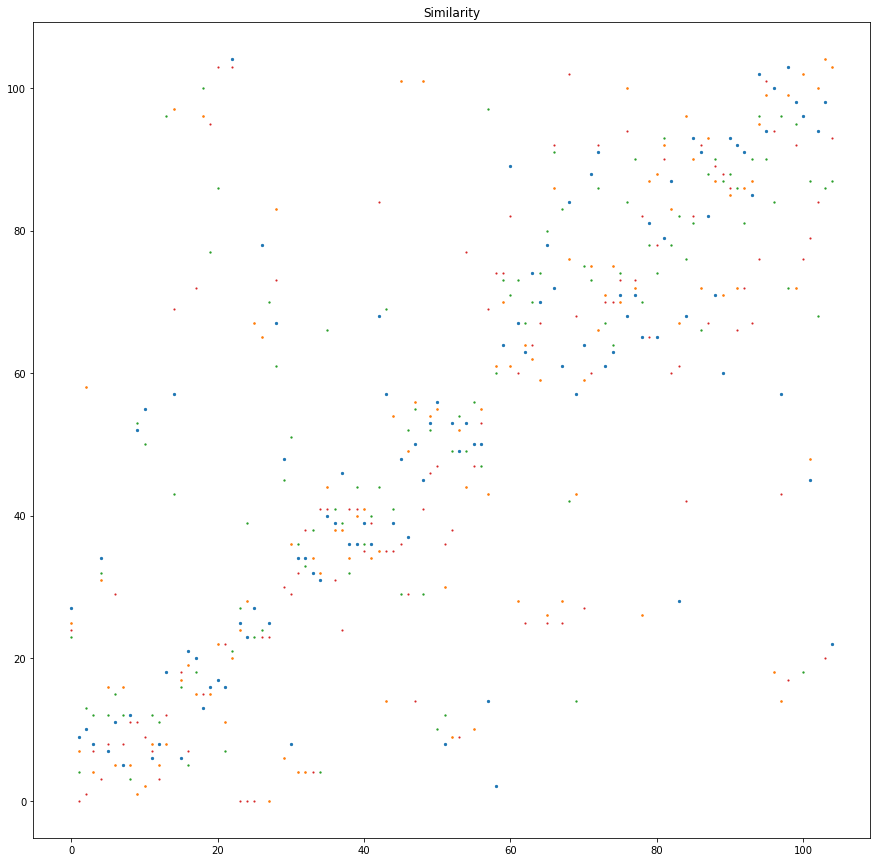

In [100]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

x = np.arange(105)
for i in range(1,5):
    y = np.array(indices[:,i])

    plt.scatter(x, y, s=5*(1/i))
#plt.scatter(dist_std_first,dist_std_first)
plt.title('Similarity')
plt.show()

## Energy

### sp

In [5]:
energies_sp = []
structuress = []
for i in range(len(structures)):
    crystal_output = Crystal_output().read_cry_output('./data/crystal/sp/CaMgO_sp_%s.out'%str(i))
    if crystal_output.get_final_energy() != None:
        energies_sp.append(crystal_output.get_final_energy())
        structuress.append(i)

### Cell

In [4]:
energies_cell = []
structuress = []
for i in range(len(structures)):
    crystal_output = Crystal_output().read_cry_output('./data/crystal/cell/CaMgO_cell_%s.out'%str(i))
    if crystal_output.get_final_energy() != None:
        energies_cell.append(crystal_output.get_final_energy())
        structuress.append(i)

### Full opt

## Gap

In [55]:
energies = []
structuress = []
for i in range(len(structures)):
    crystal_output = Crystal_output().read_cry_output('./data/crystal/sp/CaMgO_sp_%s.out'%str(i))
    if crystal_output.get_band_gap() != None:
        energies.append(crystal_output.get_band_gap())
        structuress.append(i)

# THE END

## Selected structures

In [100]:
space_groups_dict

{1: array([   5,    6,    7, ..., 4010, 4011, 4012]),
 2: array([  15,   42,   48, 2084, 2130, 2161, 2181, 2194, 2328, 2337, 2671,
        2703, 2716, 2738, 2749, 3417]),
 5: array([  17,   41,   49,  152,  185,  305,  315,  318,  327,  341,  417,
         450,  502,  593,  734,  744,  757,  762,  768,  773,  778,  877,
         919,  950,  973, 1010, 1089, 1280, 1430, 1483, 1485, 1582, 1684,
        1689, 1705, 1751, 1808, 1901, 1962, 1972, 1989, 2006, 2029, 2055,
        2061, 2078, 2097, 2127, 2139, 2145, 2190, 2193, 2199, 2202, 2240,
        2265, 2270, 2298, 2306, 2327, 2336, 2344, 2485, 2509, 2510, 2567,
        2574, 2576, 2654, 2672, 2718, 2724, 2729, 2748, 2782, 2788, 2794,
        2805, 2807, 2830, 2835, 2849, 2851, 2855, 2862, 2866, 2934, 2947,
        2963, 2978, 2981, 3077, 3088, 3100, 3109, 3112, 3119, 3169, 3187,
        3211, 3212, 3246, 3247, 3257, 3270, 3276, 3286, 3296, 3299, 3321,
        3369, 3412, 3453, 3456, 3458, 3500, 3522, 3557, 3558, 3566, 3592,
        3616

In [103]:
crystal_input = Crystal_input('data/classification/ml/cao_crystal_input.d12')
with open('data/classification/ml/qsub_input.qsub','r') as file:
    qsub_input = file.readlines()

select_structures = [3862,5]    
for structure in select_structures:
    
    write_crystal_gui('data/classification/ml/cao_%s_PBE.gui'%structure,structures[structure])
    write_crystal_input('data/classification/ml/cao_%s_PBE.d12'%structure,crystal_input=crystal_input)
    queue = qsub_input.copy()
    queue[1] = '#PBS -N %s\n'%structure
    queue.append('/rds/general/user/gmallia/home/CRYSTAL17_cx1/v2.2gnu/runcryP cao_%s_PBE'%structure)
    with open('data/classification/ml/%s.qsub'%structure, 'w') as file:
        file.writelines(queue)
    #print('qsub %s.qsub'%structure)
    

## Small_set

In [53]:
crystal_input = Crystal_input('data/classification/ml/small_set/cao_crystal_input.d12')
with open('data/classification/ml/qsub_input.qsub','r') as file:
    qsub_input = file.readlines()

for structure in range(len(structures)):
    
    write_crystal_gui('data/classification/ml/small_set/cao_%s_B3LYP.gui'%structure,structures[structure])
    write_crystal_input('data/classification/ml/small_set/cao_%s_B3LYP.d12'%structure,crystal_input=crystal_input)
    queue = qsub_input.copy()
    queue[1] = '#PBS -N %s\n'%structure
    queue.append('/rds/general/user/gmallia/home/CRYSTAL17_cx1/v2.2gnu/runcryP cao_%s_B3LYP'%structure)
    with open('data/classification/ml/small_set/%s.qsub'%structure, 'w') as file:
        file.writelines(queue)
    print('qsub %s.qsub'%structure)
    

qsub 0.qsub
qsub 1.qsub
qsub 2.qsub
qsub 3.qsub
qsub 4.qsub
qsub 5.qsub
qsub 6.qsub
qsub 7.qsub
qsub 8.qsub
qsub 9.qsub
qsub 10.qsub
qsub 11.qsub
qsub 12.qsub
qsub 13.qsub
qsub 14.qsub
qsub 15.qsub
qsub 16.qsub
qsub 17.qsub
qsub 18.qsub
qsub 19.qsub
qsub 20.qsub
qsub 21.qsub
qsub 22.qsub
qsub 23.qsub
qsub 24.qsub
qsub 25.qsub
qsub 26.qsub
qsub 27.qsub
qsub 28.qsub
qsub 29.qsub
qsub 30.qsub
qsub 31.qsub
qsub 32.qsub
qsub 33.qsub
qsub 34.qsub
qsub 35.qsub
qsub 36.qsub
qsub 37.qsub
qsub 38.qsub
qsub 39.qsub
qsub 40.qsub
qsub 41.qsub
qsub 42.qsub
qsub 43.qsub
qsub 44.qsub
qsub 45.qsub
qsub 46.qsub
qsub 47.qsub
qsub 48.qsub
qsub 49.qsub
qsub 50.qsub
qsub 51.qsub
qsub 52.qsub
qsub 53.qsub
qsub 54.qsub
qsub 55.qsub
qsub 56.qsub
qsub 57.qsub
qsub 58.qsub
qsub 59.qsub
qsub 60.qsub
qsub 61.qsub
qsub 62.qsub
qsub 63.qsub
qsub 64.qsub
qsub 65.qsub
qsub 66.qsub
qsub 67.qsub
qsub 68.qsub
qsub 69.qsub
qsub 70.qsub
qsub 71.qsub
qsub 72.qsub
qsub 73.qsub
qsub 74.qsub
qsub 75.qsub
qsub 76.qsub
qsub 77.q

## One per space group in reverse

In [ ]:
crystal_input = Crystal_input('data/classification/ml/pseudo_input.d12')
with open('data/classification/ml/qsub_input.qsub','r') as file:
    qsub_input = file.readlines()

    
for structure in reversed(np.unique(space_groups,return_counts=True, return_index=True)[1]):
    
    write_crystal_gui('data/classification/ml/pseudo/LTS_%s_PBE.gui'%structure,structures[structure],pseudo_atoms=[22])
    write_crystal_input('data/classification/ml/pseudo/LTS_%s_PBE.d12'%structure,crystal_input=crystal_input)
    queue = qsub_input.copy()
    queue[1] = '#PBS -N %s\n'%structure
    queue.append('/rds/general/user/gmallia/home/CRYSTAL17_cx1/v2.2gnu/runcryP LTS_%s_PBE'%structure)
    with open('data/classification/ml/pseudo/%s.qsub'%structure, 'w') as file:
        file.writelines(queue)
    #print('qsub %s.qsub'%structure)
    

## All space groups organised in folders

In [27]:
crystal_input = Crystal_input('data/classification/ml/crystal_input.d12')

with open('data/classification/ml/qsub_input.qsub_SAVE','r') as file:
    qsub_input = file.readlines()

for space_group in reversed(space_groups_unique[-12:]):
    #print(len(space_groups_dict[space_group]))
    queue = qsub_input.copy()
    queue[1] = '#PBS -N %s\n'%space_group

    Path('data/classification/ml/sg_%s'%space_group).mkdir(parents=True, exist_ok=True)
    for structures_n in space_groups_dict[space_group]:
        crystal_input.scf_block[0][1] = '%s %s \n'%(shrink[structures_n], shrink[structures_n]*2)
        write_crystal_gui('data/classification/ml/sg_%s/LTS_%s_PBE.gui'%(space_group,structures_n),structures[structures_n])
        write_crystal_input('data/classification/ml/sg_%s/LTS_%s_PBE.d12'%(space_group,structures_n),crystal_input=crystal_input)
        
        queue.append('/rds/general/user/gmallia/home/CRYSTAL17_cx1/v2.2gnu/runcryP LTS_%s_PBE\n'%structures_n)
    with open('data/classification/ml/sg_%s/sg_%s.qsub'%(space_group,space_group), 'w') as file:
        file.writelines(queue)
    print('cd sg_%s'%space_group)
    print('qsub sg_%s.qsub'%space_group)
    print('cd ..')

cd sg_225
qsub sg_225.qsub
cd ..
cd sg_166
qsub sg_166.qsub
cd ..
cd sg_164
qsub sg_164.qsub
cd ..
cd sg_160
qsub sg_160.qsub
cd ..
cd sg_155
qsub sg_155.qsub
cd ..
cd sg_151
qsub sg_151.qsub
cd ..
cd sg_146
qsub sg_146.qsub
cd ..
cd sg_139
qsub sg_139.qsub
cd ..
cd sg_121
qsub sg_121.qsub
cd ..
cd sg_119
qsub sg_119.qsub
cd ..
cd sg_107
qsub sg_107.qsub
cd ..
cd sg_82
qsub sg_82.qsub
cd ..


## Analyse the structures

In [15]:
import sys
sys.path.insert(1,'../../crystal-code-tools/CRYSTALpy/CRYSTALpy/')
from convert import cry_gui2pmg

initial_positions = structures[0].cart_coords
initial_cell = structures[0].lattice.matrix
structure_id = []
not_converged = []
energy = []
all_disp = []
output_folder = "data/classification/ml/outputs_optgeom/"
for file in os.listdir(output_folder):
    if file.endswith(".out"):
        structure_n = int(file.split('_')[1])
        output = Crystal_output(os.path.join(output_folder, file))
        if output.converged == True:
            structure_id.append(structure_n)
            #print(os.path.join("data/classification/ml/outputs_optgeom/", file[0:14]))

            energy.append(output.get_final_energy())
            last_geom = sorted(os.listdir(os.path.join(output_folder,"LTS_%s_PBE.optstory"%structure_n)))[-1]
            pmg_structure = cry_gui2pmg(os.path.join(output_folder,"LTS_%s_PBE.optstory/%s"%(structure_n,last_geom)))
            pmg_structure.lattice
            disp_atoms = pmg_structure.cart_coords - initial_positions
            disp_cell = pmg_structure.lattice.matrix - initial_cell
            all_disp.append(np.concatenate((disp_cell,disp_atoms),axis=0))
        else:
            not_converged.append(structure_n)


In [14]:
all_disp

[array([[ 0.00000000e+00, -1.61139691e-01, -1.61139691e-01],
        [-1.61139691e-01,  0.00000000e+00, -1.61139691e-01],
        [-1.61139691e-01, -1.61139691e-01,  0.00000000e+00],
        [-8.54427185e-02,  2.33078659e-18,  2.33078659e-18],
        [ 9.78926259e-02, -2.05319086e-01, -6.74323956e-18],
        [ 5.37132302e-02,  1.39155949e-01,  2.87965275e-18],
        [ 9.78926259e-02, -6.74323956e-18, -2.05319086e-01],
        [-1.07426460e-01, -2.05319086e-01, -2.05319086e-01],
        [-8.04660200e-02,  1.34179250e-01, -1.34179250e-01],
        [ 5.37132302e-02,  2.87965275e-18,  1.39155949e-01],
        [-8.04660200e-02, -1.34179250e-01,  1.34179250e-01],
        [ 1.87892480e-01,  1.34179250e-01,  1.34179250e-01],
        [-8.04660200e-02, -1.34179250e-01, -1.34179250e-01],
        [ 2.67527897e-02, -2.69604405e-02, -1.34179250e-01],
        [ 5.37132302e-02, -1.51382065e-17, -1.39155949e-01],
        [ 2.67527897e-02, -1.34179250e-01, -2.69604405e-02],
        [-1.07426460e-01

### Structural analysis (like LTS)

In [64]:
average_mg = []
std_average_mg = []
average_std_mg_combined = []
for n,structure in enumerate(structures):
    average = 0.
    std_average = []
    for i in mg_atoms[n]:
        for j in mg_atoms[n]: 
            if i != j:
                average += round(structure.sites[i].distance(structure.sites[j]),6)
                std_average.append(structure.sites[i].distance(structure.sites[j]))
    average_mg.append(average/((len(mg_atoms[n]))*(len(mg_atoms[n])-1)))
    std_average_mg.append(np.std(std_average))
    average_std_mg_combined.append([average/(len(mg_atoms[n])**2),np.std(std_average)])

In [65]:
unique_mg_average = np.unique(np.sort(np.array(average_mg)),axis=0)
average_mg_group = []
for i in range(len(structures)):
    average_mg_group.append(np.where(unique_mg_average == average_mg[i])[0][0])

In [67]:
dist_std_unique, dist_std_first, dist_std_occ =  \
np.unique(np.round(np.array(average_std_mg_combined),6),axis=0,return_counts=True,return_index=True)

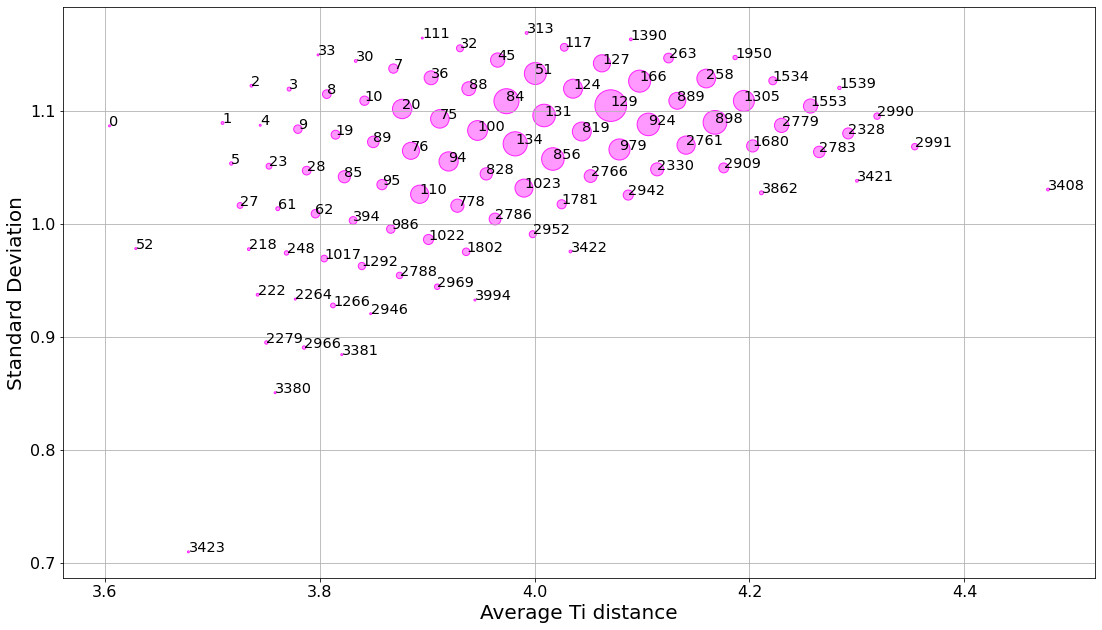

In [69]:
import matplotlib.pyplot as plt

font = {'size'   : 14.5,
       'weight': 'normal'}

plt.rc('font', **font)

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()
ax.scatter(dist_std_unique[:,0], dist_std_unique[:,1],s=dist_std_occ/max(dist_std_occ)*1000, 
           edgecolors='#ff22ff', color='#ff99ff')

label = dist_std_first

ax.set_xlabel('Average Ti distance', fontsize=20)
ax.set_ylabel('Standard Deviation', fontsize=20) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.grid()

for i, txt in enumerate(label):
    ax.annotate(txt, (dist_std_unique[i,0], dist_std_unique[i,1]),)
fig.set_size_inches(18.5, 10.5)

plt.show()

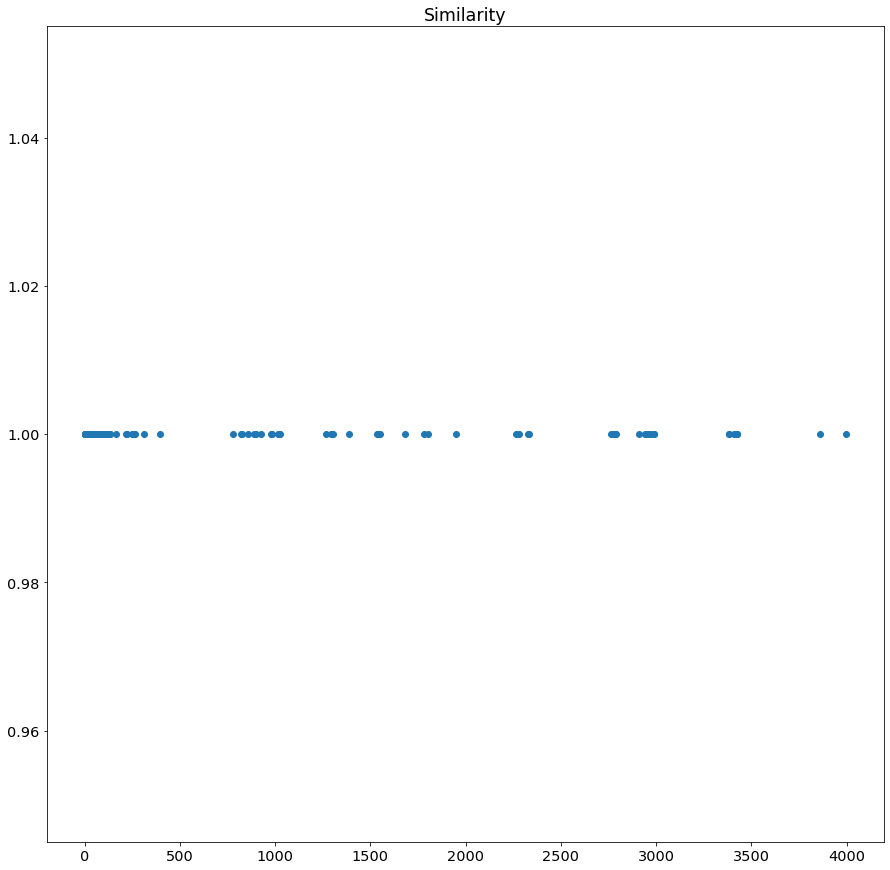

In [70]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

x = np.array(dist_std_first)

y = [1]*len(x)

plt.scatter(x, y)
plt.title('Similarity')
plt.show()

# THE END

### SHRINK test

In [ ]:
struct = cry_gui2pmg('data/classification/ml/optc021')
inp = Crystal_input('data/classification/ml/crystal_input.d12')

with open('data/classification/ml/qsub_input.qsub_SAVE','r') as file:
    qsub_input = file.readlines()

energy = []
for i in range(4,13):

    energy.append(Crystal_output('data/classification/ml/test_shrink/LTS_%s.out'%i).get_final_energy())

In [ ]:
for j,i in enumerate(energy[1:]):
    print(energy[j]-energy[j+1])

# TESTING

## THIS ONE WORKS (it scales better when a large number of shells is included)
It doesn't work for the primitive cell

In [ ]:
atom_type_1max_shell = 2
centered_sph_coords = []
centered_sph_coords_structure = []
neighbours_spatial_dist = []
neighbours_spatial_dist_all = []
import time
time0 = time.time()
for k,structure in enumerate(structures[100:105]):
    print('STRUCTURE',structure)
    time0 = time.time()
    neighbours_spatial_dist = []
    for j in range(structure.num_sites):
        centered_sph_coords = []
        for i in range(structure.num_sites):  
            print(i,j)
            translation_vector = structure.sites[j].distance_and_image(structure.sites[i])[1]
            new_cart_coords = structure.cart_coords[i]+(translation_vector*structure.lattice.abc)
            #print(translation_vector)
            #print(new_cart_coords,structure.cart_coords[i])
            centered_cart_coords = new_cart_coords-structure.cart_coords[j] 
            centered_sph_coords.append(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))        
            #print(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))
        #centered_sph_coords_all.append(centered_sph_coords)
        centered_sph_coords = np.array(centered_sph_coords)
        #print(centered_sph_coords)

        atoms_shell = []
        for unique in shells:
            atoms_shell.append(np.where(np.round(centered_sph_coords[:,2],5) == np.round(unique,5))[0].tolist())
            
        #print(atoms_shell)
        neighbours_spatial_dist_atom = []
        for shell in range(max_shell+1):
            #a = np.array(centered_sph_coords)[atoms_shell[shell]]
            spatial_distribution = np.argsort(centered_sph_coords[atoms_shell[shell]][:,1]*10 + centered_sph_coords[atoms_shell[shell]][:,0])
            #print(np.array(structure.atomic_numbers)[np.array(atoms_shell[shell])[spatial_distribution]])
            #print(np.array(atoms_shell[shell])[spatial_distribution])
            
            neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atoms_shell[shell])[spatial_distribution]]).tolist())
            #THIS IS THE CONTROL LINE
            #print(centered_sph_coords[np.array(atoms_shell[shell])[spatial_distribution]])
        neighbours_spatial_dist.append(neighbours_spatial_dist_atom)
    neighbours_spatial_dist_all.append(neighbours_spatial_dist)
    print(time.time()-time0)
    #centered_sph_coords_structure = np.array(centered_sph_coords_all)


In [4]:
def get_config_analysis_test(self):
        # Return the configuration analysis for solid solutions (CONFCON keyword in input)

        import re
        import numpy as np

        # Check this is a configuration analysis calculation
        try:
            begin = self.data.index(
                '                             CONFIGURATION ANALYSIS\n')
        except:
            return "WARNING: this is not a CONFCNT analysis."
        
        for line in self.data[::-1]:
            if '----' in line:
                dash_line = line.rstrip().lstrip()
                #print(line.rstrip(),len(line.rstrip()))
                break
        #print(dash_line)
                
        for i, line in enumerate(self.data[begin:]):
            if re.match(r'^ COMPOSITION', line):
                self.n_classes = line.split()[9]
                original_atom = str(line.split()[2])
                begin = begin+i
        config_list = []

        # Read all the configurations
        for line in self.data[begin:]:
            if not re.match(r'^   WARNING', line):
                config_list.extend(line.split())
        config_list = np.array(config_list)
        warning = np.where(config_list == 'WARNING')
        config_list = np.delete(config_list, warning)
        atom1_begin = np.where(config_list == original_atom)[0]
        atom1_end = np.where(
            config_list == dash_line)[0]
        atom2_begin = np.where(config_list == 'XX')[0]
        atom2_end = np.where(
            config_list == '<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>')[0]
        end = np.where(
            config_list == '===============================================================================')[0][-1]
        atom2_end = np.append(atom2_end, end)
        atom_type1 = []
        atom_type2 = []
        config_list = config_list.tolist()
        for i in range(len(atom1_end)):
            atom_type1.append(
                [int(x) for x in config_list[atom1_begin[i+1]+1:atom1_end[i]]])
            atom_type2.append(
                [int(x) for x in config_list[atom2_begin[i]+1:atom2_end[i]]])

        self.atom_type1 = atom_type1
        self.atom_type2 = atom_type2
        print(atom1_end)
        return [self.atom_type1, self.atom_type2]
cry_output = Crystal_output().read_cry_output('data/crystal/cao_confcount_2.out')
get_config_analysis_test(cry_output)

[ 28  52  76 100]


[[[5, 6, 7, 8], [4, 6, 7, 8], [4, 5, 7, 8], [3, 4, 5, 6]],
 [[1, 2, 3, 4], [1, 2, 3, 5], [1, 2, 3, 6], [1, 2, 7, 8]]]

In [21]:
for line in cry_output.data[::-1]:
    if '----' in line:
        dash_line = '-'*len(line)
        break
print(dash_line)

---------------------------------------------------------------------------------


In [348]:
#WIP
max_shell = 1
centered_sph_coords = []
centered_sph_coords_structure = []
neighbours_spatial_dist = []
neighbours_spatial_dist_all = []
import time
#time0 = time.time()
#for k,structure in enumerate(structures[0:100]): #TMP only calculate 100 structures
for k,structure in enumerate(structures[0:1]): 
    time0 = time.time()
    neighbours_spatial_dist = []
    
    for j in range(structure.num_sites):
        centered_sph_coords = []
        neighbours_spatial_dist_atom = []
        neighbours = []
        
        for n in range(1,max_shell+1):
            #print(Element(structure.get_neighbors_in_shell(structure.cart_coords[j],np.round(shells[n],2),0.5)))#.as_dict(verbosity=1)['species'][0]['element']).number)
            neighboursstructure.get_neighbors_in_shell(structure.cart_coords[j],np.round(shells[n],6),0.5))
            print()
            atom_indices = np.where(np.round(structure.distance_matrix[j],5) == np.round(shells[n],5))[0].tolist()
            centered_sph_coords = []
            for i in atom_indices:

                translation_vector = structure.sites[j].distance_and_image(structure.sites[i])[1]
                new_cart_coords = structure.cart_coords[i]+(translation_vector*structure.lattice.abc)
                centered_cart_coords = new_cart_coords-structure.cart_coords[j] 

                centered_sph_coords.append(cart2sph(centered_cart_coords[0],centered_cart_coords[1],centered_cart_coords[2]))        

            spatial_distribution = np.argsort(np.array(centered_sph_coords)[:,1]*10 +\
                                              np.array(centered_sph_coords)[:,0])


            neighbours_spatial_dist_atom.extend((np.array(structure.atomic_numbers)[np.array(atom_indices)[spatial_distribution]]*(1)).tolist())
        #SAVE
        neighbours_spatial_dist.append(neighbours_spatial_dist_atom)
        
    #print(time.time()-time0)
    neighbours_spatial_dist_all.append(neighbours_spatial_dist) 
#neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)    
neighbours_spatial_dist_all

0 [PeriodicSite: O (-2.4191, -0.0000, 0.0000) [0.1667, -0.1667, -0.1667], PeriodicSite: O (-0.0000, -2.4191, -0.0000) [-0.1667, 0.1667, -0.1667], PeriodicSite: O (0.0000, 0.0000, -2.4191) [-0.1667, -0.1667, 0.1667], PeriodicSite: O (-0.0000, -0.0000, 2.4191) [0.1667, 0.1667, -0.1667], PeriodicSite: O (0.0000, 2.4191, 0.0000) [0.1667, -0.1667, 0.1667], PeriodicSite: O (2.4191, 0.0000, 0.0000) [-0.1667, 0.1667, 0.1667]]

1 [PeriodicSite: O (0.0000, 2.4191, 0.0000) [0.1667, -0.1667, 0.1667], PeriodicSite: O (2.4191, 0.0000, 0.0000) [-0.1667, 0.1667, 0.1667], PeriodicSite: O (2.4191, 2.4191, -2.4191) [-0.1667, -0.1667, 0.5000], PeriodicSite: O (2.4191, 2.4191, 2.4191) [0.1667, 0.1667, 0.1667], PeriodicSite: O (2.4191, 4.8382, 0.0000) [0.1667, -0.1667, 0.5000], PeriodicSite: O (4.8382, 2.4191, 0.0000) [-0.1667, 0.1667, 0.5000]]

2 [PeriodicSite: O (-4.8382, -2.4191, 0.0000) [0.1667, -0.1667, -0.5000], PeriodicSite: O (-2.4191, -4.8382, 0.0000) [-0.1667, 0.1667, -0.5000], PeriodicSite: O (-2

[[[8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [8, 8, 8, 8, 8, 8],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [12, 12, 12, 12, 12, 12],
  [20, 20, 12, 12, 12, 20],
  [20, 20, 12, 20, 12, 12],
  [20, 20, 12, 12, 12, 20],
  [12, 12, 20, 20, 12, 20],
  [20, 12, 20, 12, 20, 12],
  [12, 12, 20,

# Classification for Machine Learning

### Ideas:

### NEW:
- classify according to the descriptor
- extract info about opt
- do a few DFT calculations -> build ML potential -> build a binary model for QA 

#### Materials:
- CaMgO2 opt STO-3G
    - atoms only
    - whole cell
- CaSrO2 opt STO-3G

#### Energy
- run scf calculations on N structures
- train the NN using the descriptor neighbours_spatial_dist_all and the corresponding energy
- get the energy of new structures from the NN using their descriptor neighbours_spatial_dist_all

#### Geometry optimisation:
- optimise the geometry of N structures
- train the NN using the descriptor neighbours_spatial_dist_all and the displacement of the atoms in the structures. This would be a Mx3 (M = number of atoms) array that contains the x,y,z displacements.
- get the displacement of atoms for a new structure
- How do we include the cell? First line added to the neighbours_spatial_dist_all array of the structure (+ padding)?

#### Tests and questions
- How many shells to use?
- Using the non optimised energy vs using the optimised energy
- For the geometry optimisation part: does starting from a NN optimised structure make the full convergence quicker?
- Does training the NN with the optimised structure energies predict the energy of what the optimised geometry would give?
- Any difference in using fractional or cartesian displacements?

#### Info for the NN:
- neighbours_spatial_dist_all: descriptor for the structures (list of 2d arrays N_atoms x M_neighbours, where the M_neighbours depends on how many shells are included)
- energy: enegy of the optimised structures (list of J energy values, where J depends on how many calculations were performed)
- all_disp: information about the total displacement from the initial structures, cell and atoms (list of J 2d arrays (3 + N_atoms x 3), where J is the number of calculations that were run and the (3 + N_atoms are the cell parameters + the atom coordinates)
- disp_cell: information about the displacement from the initial cell (list of J 2d arrays (3 x 3), where J is the number of calculations that were run
- disp_atoms: information about the displacement of the atoms from the initial structures (list of J 2d arrays (N_atoms x 3), where J is the number of calculations that were run 

#### ML ideas:
- simple cosine similarity
- NN trained on 2D descriptors
- benchmark existing decriptors (https://singroup.github.io/dscribe/latest/tutorials/tutorials.html#)
- clustering vs regression
- geometry optimisation
- giving different weights to shells

#### Possible descriptors:
- neighbours_spatial_dist_all: descriptor for the structures (list of 2d arrays N_atoms x M_neighbours, where the M_neighbours depends on how many shells are included)
- neighbours_spatial_dist_all_sorted: like neighbours_spatial_dist_all, but storted row-sorted
- neighbours_spatial_dist_all_sorted_sliced: like neighbours_spatial_dist_all_sorted, but without the central atom number
- neighbours_spatial_dist_all_sorted_sliced_flat: like neighbours_spatial_dist_all_sorted, but without the central atom number, but as a flat array
- neighbours_spatial_dist_all_sorted_sliced_sum: like neighbours_spatial_dist_all_sorted_sliced, but summed columnwise
